In [80]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tqdm

# read dataset

In [3]:
omics_files=["./data/LGG/rna.csv.gz", "./data/LGG/met.csv.gz", "./data/LGG/mirna.csv.gz"]
label_file = "./data/LGG/label.csv"

In [781]:
omics_files=["./data/GBM/GBM.expression.csv.gz", "./data/GBM/GBM.met.csv.gz", "./data/GBM/GBM.cnv.csv.gz"]
label_file = "./data/GBM/labels.csv"

In [783]:
df = pd.read_csv(omics_files[0], compression='gzip')
df = df.set_index('gene').T.sort_index()
dat = df.values

In [798]:
labels = pd.read_csv(label_file)
labels = labels.sort_values('patient_id')
labels = labels[labels.patient_id.isin(df.index.values)]
patients = labels.patient_id.values
labels = labels.label.values
labels

array([1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [801]:
df.loc[patients, :]

gene,65985,11167,63916,6205,9240,4313,23034,6604,51146,23051,...,66035,4318,2822,4218,113791,6232,6633,25800,1075,364
TCGA.02.0001,6.5006,8.7297,5.5114,10.9848,7.5352,8.6740,5.0326,4.7110,5.1085,5.0578,...,3.8104,10.1073,4.2646,9.0489,6.0540,12.9119,11.8723,6.8677,10.3541,4.7099
TCGA.02.0003,6.5392,9.7944,6.2140,10.8112,6.9979,9.3486,5.0270,5.3277,4.3486,5.0185,...,3.8114,9.2451,4.3928,8.8645,6.6742,13.4194,11.1097,8.1478,11.3674,4.1964
TCGA.02.0007,7.1869,4.9451,5.2304,10.4773,8.3561,4.4295,5.1759,4.4405,4.8242,5.3092,...,4.0554,4.9841,4.3993,8.4836,5.0602,13.5751,11.6656,9.1899,11.4782,4.3231
TCGA.02.0009,7.6750,10.8401,6.6207,10.6373,6.9429,9.4522,5.1649,4.9522,4.2046,5.1934,...,3.7961,9.4838,4.1058,9.2392,6.4780,13.2870,11.4804,8.5564,10.4047,4.6391
TCGA.02.0010,7.9960,8.9316,7.5524,11.0015,8.0444,4.5017,4.9701,8.6390,4.7297,5.6876,...,4.3457,6.3779,4.4098,9.3678,5.7048,13.4803,10.9516,9.2099,8.4179,4.1673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.41.2572,7.5645,10.6261,7.8302,10.9741,9.5121,8.5686,5.9985,8.8063,4.4073,7.1416,...,4.1320,5.9047,4.3830,8.9496,5.6664,13.0449,11.5326,9.1437,8.6466,3.9359
TCGA.41.2575,7.4707,9.0223,7.2680,11.1522,9.0870,8.1914,5.3809,9.4080,4.3760,6.8908,...,4.2864,5.6763,4.6100,8.5116,6.0337,13.4874,11.4938,9.9421,8.5357,3.8522
TCGA.41.3392,7.7575,10.1369,7.7922,11.2145,10.4248,7.9187,5.6151,10.1912,4.1216,7.0976,...,4.2259,7.6174,4.2795,8.7327,7.0284,13.2740,11.7869,9.0605,8.7931,3.6826
TCGA.41.3393,7.1475,9.7595,7.7017,10.9388,9.6555,8.5737,6.0901,8.5130,4.1553,6.8399,...,4.2960,7.9491,4.3866,9.2732,5.9184,13.0283,11.2973,9.6774,10.2152,3.8290


# KS Test

In [789]:
data = dat[:, 0]

In [790]:
def check(data, labels, seed=0):
    # check label0 vs. label1: need (p<0.05)
    label_1 = [True if i==1 else False for i in labels]
    label_0 = [True if i==0 else False for i in labels]
    pvalue_01 = stats.kstest(data[label_1], data[label_0]).pvalue
    
    # check train vs. test for total data: need (p>0.05)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=seed)
    pvalue_tt = stats.kstest(X_train, X_test).pvalue
    
    # check label0 vs. label1 in training dataset (p<0.05)
    label_1 = [True if i==1 else False for i in y_train]
    label_0 = [True if i==0 else False for i in y_train]
    pvalue_01_train = stats.kstest(X_train[label_1], X_train[label_0]).pvalue
    
    # check label0 vs. label1 in testing dataset (p<0.05)
    label_1 = [True if i==1 else False for i in y_test]
    label_0 = [True if i==0 else False for i in y_test]
    pvalue_01_test = stats.kstest(X_test[label_1], X_test[label_0]).pvalue
    
    # label1: train vs. test: p>0.05
    label_1_test = [True if i==1 else False for i in y_test]
    label_1_train = [True if i==1 else False for i in y_train]
    pvalue_1_tt = stats.kstest(X_test[label_1_test], X_train[label_1_train]).pvalue
    
    # label0: train vs. test: p>0.05
    label_0_test = [True if i==0 else False for i in y_test]
    label_0_train = [True if i==0 else False for i in y_train]
    pvalue_0_tt = stats.kstest(X_test[label_0_test], X_train[label_0_train]).pvalue
    
    
    return pvalue_01, pvalue_tt, pvalue_01_train, pvalue_01_test, pvalue_1_tt, pvalue_0_tt


## RNA

In [804]:
df = pd.read_csv(omics_files[0], compression='gzip')
df = df.set_index('gene').T.sort_index()
df = df.loc[patients, :]
dat = df.values

dat_rna = dat


In [792]:
labels = pd.read_csv(label_file)
labels = labels.sort_values('patient_id')
labels = labels[labels.patient_id.isin(df.index.values)]
labels = labels.label.values

In [805]:
np.random.seed(42)
seeds = np.random.randint(0, 1000, 10)

candidates_list = []
candidates_list.append(range(dat.shape[1]))

for n, seed in enumerate(seeds):
    candidates_list.append([])
    for i in tqdm.tqdm(candidates_list[n]):
        data = dat[:, i]
        pvalue_01, pvalue_tt, pvalue_01_train, pvalue_01_test, pvalue_1_tt, pvalue_0_tt = check(data=data, labels=labels, seed=seed)
        if pvalue_01 < 0.05 and pvalue_tt > 0.05 and pvalue_01_train < 0.05 and pvalue_01_test < 0.05 and pvalue_1_tt > 0.05 and pvalue_0_tt > 0.05:
            candidates_list[n+1].append(i)
    print("Seed: {} | Candidates' Number: {}".format(seed, len(candidates_list[n+1])))


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 8574/8574 [00:35<00:00, 240.91it/s]


Seed: 102 | Candidates' Number: 85


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:00<00:00, 235.92it/s]


Seed: 435 | Candidates' Number: 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 231.48it/s]


Seed: 860 | Candidates' Number: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 216.40it/s]


Seed: 270 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 106 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 71 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 700 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 20 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 614 | Candidates' Number: 0


0it [00:00, ?it/s]

Seed: 121 | Candidates' Number: 0


In [806]:
candidates_rna = candidates_list

## Met

In [807]:
df = pd.read_csv(omics_files[1], compression='gzip')
df = df.set_index('gene').T.sort_index()
df = df.loc[patients, :]
dat = df.values

dat_met = dat

In [730]:
labels = pd.read_csv(label_file)
labels = labels.sort_values('patient_id')
labels = labels[labels.patient_id.isin(df.index.values)]
labels = labels.label.values

In [808]:
np.random.seed(42)
seeds = np.random.randint(0, 1000, 20)

candidates_list = []
candidates_list.append(range(dat.shape[1]))

for n, seed in enumerate(seeds):
    candidates_list.append([])
    for i in tqdm.tqdm(candidates_list[n]):
        data = dat[:, i]
        pvalue_01, pvalue_tt, pvalue_01_train, pvalue_01_test, pvalue_1_tt, pvalue_0_tt = check(data=data, labels=labels, seed=seed)
        if pvalue_01 < 0.05 and pvalue_tt > 0.05 and pvalue_01_train < 0.05 and pvalue_01_test < 0.05 and pvalue_1_tt > 0.05 and pvalue_0_tt > 0.05:
            candidates_list[n+1].append(i)
    print("Seed: {} | Candidates' Number: {}".format(seed, len(candidates_list[n+1])))


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 8574/8574 [00:36<00:00, 233.85it/s]


Seed: 102 | Candidates' Number: 68


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 235.55it/s]


Seed: 435 | Candidates' Number: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 233.55it/s]


Seed: 860 | Candidates' Number: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 216.80it/s]


Seed: 270 | Candidates' Number: 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 214.70it/s]


Seed: 106 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 71 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 700 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 20 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 614 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 121 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 466 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 214 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 330 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 458 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 87 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 372 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 99 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 871 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 663 | Candidates' Number: 0


0it [00:00, ?it/s]

Seed: 130 | Candidates' Number: 0


In [809]:
candidates_met = candidates_list

## CNV

In [810]:
df = pd.read_csv(omics_files[2], compression='gzip')
df = df.set_index('gene').T.sort_index()
df = df.loc[patients, :]
dat = df.values

dat_cnv = dat

In [811]:
np.random.seed(42)
seeds = np.random.randint(0, 1000, 20)

candidates_list = []
candidates_list.append(range(dat.shape[1]))

for n, seed in enumerate(seeds):
    candidates_list.append([])
    for i in tqdm.tqdm(candidates_list[n]):
        data = dat[:, i]
        pvalue_01, pvalue_tt, pvalue_01_train, pvalue_01_test, pvalue_1_tt, pvalue_0_tt = check(data=data, labels=labels, seed=seed)
        if pvalue_01 < 0.05 and pvalue_tt > 0.05 and pvalue_01_train < 0.05 and pvalue_01_test < 0.05 and pvalue_1_tt > 0.05 and pvalue_0_tt > 0.05:
            candidates_list[n+1].append(i)
    print("Seed: {} | Candidates' Number: {}".format(seed, len(candidates_list[n+1])))


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 8574/8574 [00:36<00:00, 233.19it/s]


Seed: 102 | Candidates' Number: 185


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 185/185 [00:00<00:00, 232.55it/s]


Seed: 435 | Candidates' Number: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 225.14it/s]


Seed: 860 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 270 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 106 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 71 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 700 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 20 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 614 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 121 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 466 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 214 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 330 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 458 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 87 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 372 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 99 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 871 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 663 | Candidates' Number: 0


0it [00:00, ?it/s]

Seed: 130 | Candidates' Number: 0


In [812]:
candidates_cnv = candidates_list

## miRNA

In [376]:
df = pd.read_csv(omics_files[2], compression='gzip')
df = df.sort_values('patient_id')
df = df.set_index('patient_id')
dat = df.values

dat_mirna = dat


dat.shape

(510, 791)

In [321]:
labels = pd.read_csv(label_file)
labels = labels.sort_values('patient_id')
labels = labels[labels.patient_id.isin(df.index.values)]
labels = labels.label.values
labels

array([0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,

In [322]:
np.random.seed(42)
seeds = np.random.randint(0, 1000, 10)

candidates_list = []
candidates_list.append(range(dat.shape[1]))

for n, seed in enumerate(seeds):
    candidates_list.append([])
    for i in tqdm.tqdm(candidates_list[n]):
        data = dat[:, i]
        pvalue_01, pvalue_tt, pvalue_01_train, pvalue_01_test, pvalue_1_tt, pvalue_0_tt = check(data=data, labels=labels, seed=seed)
        if pvalue_01 < 0.05 and pvalue_tt > 0.05 and pvalue_01_train < 0.05 and pvalue_01_test < 0.05 and pvalue_1_tt > 0.05 and pvalue_0_tt > 0.05:
            candidates_list[n+1].append(i)
    print("Seed: {} | Candidates' Number: {}".format(seed, len(candidates_list[n+1])))


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 791/791 [00:06<00:00, 129.84it/s]


Seed: 102 | Candidates' Number: 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 126.09it/s]


Seed: 435 | Candidates' Number: 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 122.63it/s]


Seed: 860 | Candidates' Number: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 120.31it/s]


Seed: 270 | Candidates' Number: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 117.12it/s]


Seed: 106 | Candidates' Number: 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 112.31it/s]


Seed: 71 | Candidates' Number: 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 121.70it/s]


Seed: 700 | Candidates' Number: 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 122.66it/s]


Seed: 20 | Candidates' Number: 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 121.85it/s]


Seed: 614 | Candidates' Number: 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 123.69it/s]

Seed: 121 | Candidates' Number: 6


In [323]:
candidates_mirna = candidates_list

# MOGONET

In [755]:
rna_tr, rna_te, met_tr, met_te, mir_tr, mir_te, la_tr, la_te = train_test_split(dat_rna[:, candidates_rna[10]], 
                                                 dat_met[:, candidates_met[10]], 
                                                 dat_mirna[:, candidates_mirna[2]],
                                                 labels,
                                                 test_size=0.3, 
                                                 random_state=seeds[-1]
                                                )

In [768]:
rna_tr = np.nan_to_num(rna_tr)
rna_te = np.nan_to_num(rna_te)
np.savetxt("./lgg/1_tr.csv", rna_tr, delimiter=",")
np.savetxt("./lgg/1_te.csv", rna_te, delimiter=",")

met_tr = np.nan_to_num(met_tr)
met_te = np.nan_to_num(met_te)
np.savetxt("./lgg/2_tr.csv", met_tr, delimiter=",")
np.savetxt("./lgg/2_te.csv", met_te, delimiter=",")

mir_tr = np.nan_to_num(mir_tr)
mir_te = np.nan_to_num(mir_te)
np.savetxt("./lgg/3_tr.csv", mir_tr, delimiter=",")
np.savetxt("./lgg/3_te.csv", mir_te, delimiter=",")

np.savetxt("./lgg/labels_te.csv", la_te.astype(np.float32), delimiter="\n")
np.savetxt("./lgg/labels_tr.csv", la_tr.astype(np.float32), delimiter="\n")

In [766]:
np.savetxt("./lgg/1_featname.csv" ,np.array(candidates_rna[10]), delimiter="\n")
np.savetxt("./lgg/2_featname.csv" ,np.array(candidates_met[10]), delimiter="\n")
np.savetxt("./lgg/3_featname.csv" ,np.array(candidates_mirna[2]), delimiter="\n")

# 构建机器学习模型

In [813]:
data = np.concatenate([dat_rna[:, candidates_rna[1]], dat_met[:, candidates_met[1]], dat_cnv[:, candidates_cnv[1]] ], 1)

data = np.nan_to_num(data)

data = data.astype('float32')

In [814]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=seeds[-1]) 

In [815]:
from sklearn.ensemble import RandomForestClassifier     #导入需要的模块

rfc = RandomForestClassifier( n_jobs=-1)                      #实例化
rfc = rfc.fit(X_train,y_train)                      #用训练集数据训练模型
result = rfc.score(X_test,y_test) 

result

0.7575757575757576

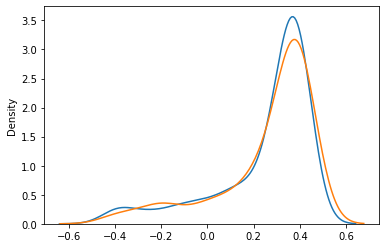

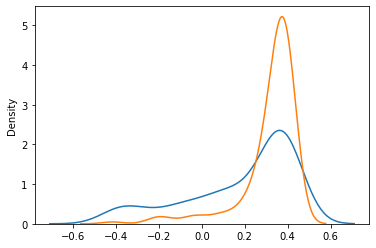

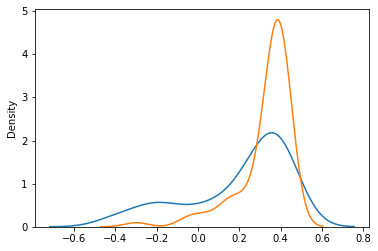

In [288]:
i = 10
sns.kdeplot(X_train[:,i])
sns.kdeplot(X_test[:,i])
plt.show()

idx = [True if i == 1 else False for i in y_train]
sns.kdeplot(X_train[:,i][idx])
idx = [True if i == 0 else False for i in y_train]
sns.kdeplot(X_train[:,i][idx])
plt.show()

idx = [True if i == 1 else False for i in y_test]
sns.kdeplot(X_test[:,i][idx])
idx = [True if i == 0 else False for i in y_test]
sns.kdeplot(X_test[:,i][idx])
plt.show()

In [432]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn import metrics

model = XGBClassifier(learning_rate=0.001,
                      n_estimators=100,           # 树的个数-10棵树建立xgboost
                      max_depth=10,               # 树的深度
                      min_child_weight = 1,      # 叶子节点最小权重
                      gamma=0.,                  # 惩罚项中叶子结点个数前的参数
                      subsample=1,               # 所有样本建立决策树
                      colsample_btree=1,         # 所有特征建立决策树
                      scale_pos_weight=1,        # 解决样本个数不平衡的问题
                      random_state=27,           # 随机数
                      slient = 0
                      )
model.fit(X_train,
          y_train)

[15:39:48] WARNING: ../src/learner.cc:627: 
Parameters: { "colsample_btree", "slient" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_btree=1, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=1, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=0.0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.001, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=10, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=27, reg_alpha=0, ...)

In [433]:
#预测
y_test, y_pred = y_test, model.predict(X_test)
print("Accuracy : %.4g" % metrics.accuracy_score(y_test, y_pred)) 
y_train_proba = model.predict_proba(X_train)[:,1]
print("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, y_train_proba))
y_proba = model.predict_proba(X_test)[:,1]
print("AUC Score (Test): %f" % metrics.roc_auc_score(y_test, y_proba))

Accuracy : 0.6209
AUC Score (Train): 0.996874
AUC Score (Test): 0.689812


# 构建Deep learning 模型

In [738]:
import os, sys, torch, dgl
import numpy as np
import pandas as pd
from util import check_files
from data_ import *
from train import *
from torch_geometric.data import Data

from turtle import forward
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import dgl
import dgl.nn.pytorch as dglnn
# from dgl.nn import Set2Set

from torch_geometric.nn import SAGEConv, SAGPooling, Set2Set, GraphNorm, global_sort_pool, GlobalAttention
from torch_geometric.utils import add_self_loops, subgraph
# from torch_geometric.loader import DataLoader

from torch_geometric.data import Data

In [739]:
def evaluate(logits, real_labels):
    """
    logits: sigmoid
    real_labels (numpy.array, dim=1)
    
    Return
        acc, auc, f1_score_, sens, spec
    """
    # acc
    pred = [1 if i > 0.5 else 0 for i in logits]
    acc = np.sum(np.array(pred) == np.array(real_labels)) / len(real_labels)
    # matrix
    TN, FP, FN, TP = confusion_matrix(y_true=real_labels, y_pred=pred).ravel()
    # auc
    fpr, tpr, thresholds = metrics.roc_curve(real_labels, logits, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    # F1 score
    f1_score_ = f1_score(y_true=real_labels, y_pred=pred)
    # sens
    sens = TP/float(TP+FN)
    # spec
    spec = TN/float(TN+FP)
    return acc, auc, f1_score_, sens, spec

In [817]:
data = np.concatenate([dat_rna[:, candidates_rna[1]], dat_met[:, candidates_met[1]], dat_cnv[:, candidates_cnv[1]] ], 1)

data = np.nan_to_num(data)

data = data.astype('float32')

# data = torch.tensor([data, labels], dtype=torch.float32)
dataset = []
for i in range(len(labels)):
    dataset.append([torch.tensor(data[i]), torch.tensor(labels[i])])
    
data.shape, labels.shape

((220, 338), (220,))

In [820]:
class DeepMOI(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(DeepMOI, self).__init__()
        self.lin1 = nn.Linear(in_feat, 256)
        self.lin2 = nn.Linear(256, 128)
        self.lin3 = nn.Linear(128, 64)
        self.lin4 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.lin1(x)
        x = torch.relu(x)
#         x = F.leaky_relu(x, 0.25)
        x = F.dropout(x, 0.5)
        
        x = self.lin2(x)
        x = torch.relu(x)
#         x = F.leaky_relu(x, 0.25)
        x = F.dropout(x, 0.5)
        
        x = self.lin3(x)
        x = torch.relu(x)
#         x = F.leaky_relu(x, 0.25)
        x = F.dropout(x, 0.5)
        
#         x = nn.Dropout(p=0.4)(x)
        x = self.lin4(x)
        logit = torch.sigmoid(x)
        
        return logit

In [821]:
indim= data.shape[1]
model = DeepMOI(indim, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)

dataset_train, dataset_test = train_test_split(dataset, test_size=0.3, random_state=seeds[-1]) 
loader = DataLoader(dataset_train, batch_size=16)

for epoch in range(500):
    model.train()
    loss_epoch = []
    for batch_ndx, sample in enumerate(loader):
        X = sample[0]
        Y = sample[1]
        logits = model(X)
        loss = nn.BCELoss()(logits, Y.reshape(-1,1).to(torch.float32))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_epoch.append(loss.item())
        
    loss_epoch = np.mean(loss_epoch)
    
    y_train_proba, y_train = [], []
    for d in dataset_train:
        y_train_proba.append(model(d[0]).detach().numpy())
        y_train.append(d[1])
    acc, auc, f1_score_, sens, spec = evaluate(logits=y_train_proba, real_labels=y_train)
    print('Epoch {:2d} | Train_Loss {:.10f} | Train_ACC {:.3f} | Train_AUC {:.3f} | Train_F1_score {:.3f} | Train_Sens {:.3f} | Train_Spec {:.3f}'.format(
            epoch, loss_epoch, acc, auc, f1_score_, sens, spec)
            )
   
    y_test_proba, y_test = [], []
    for d in dataset_test:
        y_test_proba.append(model(d[0]).detach().numpy())
        y_test.append(d[1])
    acc, auc, f1_score_, sens, spec = evaluate(logits=y_test_proba, real_labels=y_test)
    print('Epoch {:2d} | Test_Loss  {:.10f} | Test_ACC  {:.3f} | Test_AUC  {:.3f} | Test_F1_score  {:.3f} | Test_Sens  {:.3f} | Test_Spec  {:.3f}\n'.format(
                epoch, loss_epoch, acc, auc, f1_score_, sens, spec))

Epoch  0 | Train_Loss 0.7028195441 | Train_ACC 0.656 | Train_AUC 0.436 | Train_F1_score 0.776 | Train_Sens 0.786 | Train_Spec 0.243
Epoch  0 | Test_Loss  0.7028195441 | Test_ACC  0.652 | Test_AUC  0.554 | Test_F1_score  0.772 | Test_Sens  0.736 | Test_Spec  0.308

Epoch  1 | Train_Loss 0.6625276923 | Train_ACC 0.727 | Train_AUC 0.588 | Train_F1_score 0.835 | Train_Sens 0.906 | Train_Spec 0.162
Epoch  1 | Test_Loss  0.6625276923 | Test_ACC  0.742 | Test_AUC  0.472 | Test_F1_score  0.847 | Test_Sens  0.887 | Test_Spec  0.154

Epoch  2 | Train_Loss 0.6356121778 | Train_ACC 0.734 | Train_AUC 0.506 | Train_F1_score 0.844 | Train_Sens 0.949 | Train_Spec 0.054
Epoch  2 | Test_Loss  0.6356121778 | Test_ACC  0.758 | Test_AUC  0.492 | Test_F1_score  0.862 | Test_Sens  0.943 | Test_Spec  0.000

Epoch  3 | Train_Loss 0.5891412318 | Train_ACC 0.766 | Train_AUC 0.535 | Train_F1_score 0.865 | Train_Sens 0.983 | Train_Spec 0.081
Epoch  3 | Test_Loss  0.5891412318 | Test_ACC  0.773 | Test_AUC  0.518 | 

Epoch 32 | Test_Loss  0.5286480367 | Test_ACC  0.803 | Test_AUC  0.607 | Test_F1_score  0.891 | Test_Sens  1.000 | Test_Spec  0.000

Epoch 33 | Train_Loss 0.5181653291 | Train_ACC 0.760 | Train_AUC 0.716 | Train_F1_score 0.863 | Train_Sens 1.000 | Train_Spec 0.000
Epoch 33 | Test_Loss  0.5181653291 | Test_ACC  0.788 | Test_AUC  0.537 | Test_F1_score  0.881 | Test_Sens  0.981 | Test_Spec  0.000

Epoch 34 | Train_Loss 0.5317592621 | Train_ACC 0.760 | Train_AUC 0.689 | Train_F1_score 0.863 | Train_Sens 1.000 | Train_Spec 0.000
Epoch 34 | Test_Loss  0.5317592621 | Test_ACC  0.803 | Test_AUC  0.460 | Test_F1_score  0.891 | Test_Sens  1.000 | Test_Spec  0.000

Epoch 35 | Train_Loss 0.5204297334 | Train_ACC 0.760 | Train_AUC 0.565 | Train_F1_score 0.863 | Train_Sens 1.000 | Train_Spec 0.000
Epoch 35 | Test_Loss  0.5204297334 | Test_ACC  0.803 | Test_AUC  0.482 | Test_F1_score  0.891 | Test_Sens  1.000 | Test_Spec  0.000

Epoch 36 | Train_Loss 0.5345824480 | Train_ACC 0.760 | Train_AUC 0.717 |

Epoch 65 | Test_Loss  0.4902280539 | Test_ACC  0.773 | Test_AUC  0.730 | Test_F1_score  0.867 | Test_Sens  0.925 | Test_Spec  0.154

Epoch 66 | Train_Loss 0.4788382292 | Train_ACC 0.799 | Train_AUC 0.769 | Train_F1_score 0.882 | Train_Sens 0.991 | Train_Spec 0.189
Epoch 66 | Test_Loss  0.4788382292 | Test_ACC  0.803 | Test_AUC  0.666 | Test_F1_score  0.887 | Test_Sens  0.962 | Test_Spec  0.154

Epoch 67 | Train_Loss 0.4703451395 | Train_ACC 0.786 | Train_AUC 0.814 | Train_F1_score 0.876 | Train_Sens 1.000 | Train_Spec 0.108
Epoch 67 | Test_Loss  0.4703451395 | Test_ACC  0.758 | Test_AUC  0.626 | Test_F1_score  0.860 | Test_Sens  0.925 | Test_Spec  0.077

Epoch 68 | Train_Loss 0.4634212077 | Train_ACC 0.773 | Train_AUC 0.761 | Train_F1_score 0.867 | Train_Sens 0.974 | Train_Spec 0.135
Epoch 68 | Test_Loss  0.4634212077 | Test_ACC  0.758 | Test_AUC  0.704 | Test_F1_score  0.860 | Test_Sens  0.925 | Test_Spec  0.077

Epoch 69 | Train_Loss 0.4974049598 | Train_ACC 0.786 | Train_AUC 0.810 |

Epoch 99 | Test_Loss  0.4539133221 | Test_ACC  0.758 | Test_AUC  0.729 | Test_F1_score  0.855 | Test_Sens  0.887 | Test_Spec  0.231

Epoch 100 | Train_Loss 0.4199015528 | Train_ACC 0.792 | Train_AUC 0.857 | Train_F1_score 0.871 | Train_Sens 0.923 | Train_Spec 0.378
Epoch 100 | Test_Loss  0.4199015528 | Test_ACC  0.727 | Test_AUC  0.746 | Test_F1_score  0.830 | Test_Sens  0.830 | Test_Spec  0.308

Epoch 101 | Train_Loss 0.4494855165 | Train_ACC 0.838 | Train_AUC 0.818 | Train_F1_score 0.902 | Train_Sens 0.983 | Train_Spec 0.378
Epoch 101 | Test_Loss  0.4494855165 | Test_ACC  0.788 | Test_AUC  0.761 | Test_F1_score  0.873 | Test_Sens  0.906 | Test_Spec  0.308

Epoch 102 | Train_Loss 0.4228491262 | Train_ACC 0.831 | Train_AUC 0.822 | Train_F1_score 0.898 | Train_Sens 0.974 | Train_Spec 0.378
Epoch 102 | Test_Loss  0.4228491262 | Test_ACC  0.758 | Test_AUC  0.797 | Test_F1_score  0.855 | Test_Sens  0.887 | Test_Spec  0.231

Epoch 103 | Train_Loss 0.4137172699 | Train_ACC 0.825 | Train_AUC 

Epoch 133 | Test_Loss  0.3961412117 | Test_ACC  0.758 | Test_AUC  0.716 | Test_F1_score  0.849 | Test_Sens  0.849 | Test_Spec  0.385

Epoch 134 | Train_Loss 0.4156936646 | Train_ACC 0.825 | Train_AUC 0.845 | Train_F1_score 0.891 | Train_Sens 0.940 | Train_Spec 0.459
Epoch 134 | Test_Loss  0.4156936646 | Test_ACC  0.742 | Test_AUC  0.787 | Test_F1_score  0.841 | Test_Sens  0.849 | Test_Spec  0.308

Epoch 135 | Train_Loss 0.4069954827 | Train_ACC 0.838 | Train_AUC 0.851 | Train_F1_score 0.898 | Train_Sens 0.940 | Train_Spec 0.514
Epoch 135 | Test_Loss  0.4069954827 | Test_ACC  0.742 | Test_AUC  0.675 | Test_F1_score  0.841 | Test_Sens  0.849 | Test_Spec  0.308

Epoch 136 | Train_Loss 0.4313891411 | Train_ACC 0.857 | Train_AUC 0.834 | Train_F1_score 0.911 | Train_Sens 0.966 | Train_Spec 0.514
Epoch 136 | Test_Loss  0.4313891411 | Test_ACC  0.773 | Test_AUC  0.675 | Test_F1_score  0.862 | Test_Sens  0.887 | Test_Spec  0.308

Epoch 137 | Train_Loss 0.3697540194 | Train_ACC 0.851 | Train_AUC

Epoch 167 | Train_Loss 0.3740883380 | Train_ACC 0.864 | Train_AUC 0.846 | Train_F1_score 0.914 | Train_Sens 0.957 | Train_Spec 0.568
Epoch 167 | Test_Loss  0.3740883380 | Test_ACC  0.758 | Test_AUC  0.679 | Test_F1_score  0.849 | Test_Sens  0.849 | Test_Spec  0.385

Epoch 168 | Train_Loss 0.3906298026 | Train_ACC 0.870 | Train_AUC 0.866 | Train_F1_score 0.919 | Train_Sens 0.966 | Train_Spec 0.568
Epoch 168 | Test_Loss  0.3906298026 | Test_ACC  0.758 | Test_AUC  0.695 | Test_F1_score  0.849 | Test_Sens  0.849 | Test_Spec  0.385

Epoch 169 | Train_Loss 0.3812130690 | Train_ACC 0.870 | Train_AUC 0.875 | Train_F1_score 0.919 | Train_Sens 0.966 | Train_Spec 0.568
Epoch 169 | Test_Loss  0.3812130690 | Test_ACC  0.682 | Test_AUC  0.731 | Test_F1_score  0.800 | Test_Sens  0.792 | Test_Spec  0.231

Epoch 170 | Train_Loss 0.3797435567 | Train_ACC 0.864 | Train_AUC 0.875 | Train_F1_score 0.914 | Train_Sens 0.957 | Train_Spec 0.568
Epoch 170 | Test_Loss  0.3797435567 | Test_ACC  0.727 | Test_AUC  

Epoch 200 | Train_Loss 0.3447795644 | Train_ACC 0.870 | Train_AUC 0.903 | Train_F1_score 0.918 | Train_Sens 0.957 | Train_Spec 0.595
Epoch 200 | Test_Loss  0.3447795644 | Test_ACC  0.727 | Test_AUC  0.698 | Test_F1_score  0.830 | Test_Sens  0.830 | Test_Spec  0.308

Epoch 201 | Train_Loss 0.3638599426 | Train_ACC 0.857 | Train_AUC 0.907 | Train_F1_score 0.911 | Train_Sens 0.957 | Train_Spec 0.541
Epoch 201 | Test_Loss  0.3638599426 | Test_ACC  0.727 | Test_AUC  0.713 | Test_F1_score  0.830 | Test_Sens  0.830 | Test_Spec  0.308

Epoch 202 | Train_Loss 0.3381670162 | Train_ACC 0.890 | Train_AUC 0.915 | Train_F1_score 0.929 | Train_Sens 0.957 | Train_Spec 0.676
Epoch 202 | Test_Loss  0.3381670162 | Test_ACC  0.712 | Test_AUC  0.752 | Test_F1_score  0.822 | Test_Sens  0.830 | Test_Spec  0.231

Epoch 203 | Train_Loss 0.3722749546 | Train_ACC 0.870 | Train_AUC 0.904 | Train_F1_score 0.917 | Train_Sens 0.940 | Train_Spec 0.649
Epoch 203 | Test_Loss  0.3722749546 | Test_ACC  0.742 | Test_AUC  

Epoch 231 | Train_Loss 0.3219379544 | Train_ACC 0.864 | Train_AUC 0.892 | Train_F1_score 0.912 | Train_Sens 0.932 | Train_Spec 0.649
Epoch 231 | Test_Loss  0.3219379544 | Test_ACC  0.758 | Test_AUC  0.705 | Test_F1_score  0.846 | Test_Sens  0.830 | Test_Spec  0.462

Epoch 232 | Train_Loss 0.3374290213 | Train_ACC 0.877 | Train_AUC 0.915 | Train_F1_score 0.922 | Train_Sens 0.957 | Train_Spec 0.622
Epoch 232 | Test_Loss  0.3374290213 | Test_ACC  0.727 | Test_AUC  0.640 | Test_F1_score  0.833 | Test_Sens  0.849 | Test_Spec  0.231

Epoch 233 | Train_Loss 0.3280839562 | Train_ACC 0.883 | Train_AUC 0.926 | Train_F1_score 0.925 | Train_Sens 0.949 | Train_Spec 0.676
Epoch 233 | Test_Loss  0.3280839562 | Test_ACC  0.712 | Test_AUC  0.765 | Test_F1_score  0.819 | Test_Sens  0.811 | Test_Spec  0.308

Epoch 234 | Train_Loss 0.3062093258 | Train_ACC 0.890 | Train_AUC 0.909 | Train_F1_score 0.929 | Train_Sens 0.957 | Train_Spec 0.676
Epoch 234 | Test_Loss  0.3062093258 | Test_ACC  0.727 | Test_AUC  

Epoch 264 | Train_Loss 0.2969244234 | Train_ACC 0.883 | Train_AUC 0.908 | Train_F1_score 0.924 | Train_Sens 0.932 | Train_Spec 0.730
Epoch 264 | Test_Loss  0.2969244234 | Test_ACC  0.742 | Test_AUC  0.694 | Test_F1_score  0.832 | Test_Sens  0.792 | Test_Spec  0.538

Epoch 265 | Train_Loss 0.3045957759 | Train_ACC 0.903 | Train_AUC 0.939 | Train_F1_score 0.937 | Train_Sens 0.949 | Train_Spec 0.757
Epoch 265 | Test_Loss  0.3045957759 | Test_ACC  0.742 | Test_AUC  0.675 | Test_F1_score  0.838 | Test_Sens  0.830 | Test_Spec  0.385

Epoch 266 | Train_Loss 0.3051096655 | Train_ACC 0.883 | Train_AUC 0.932 | Train_F1_score 0.924 | Train_Sens 0.940 | Train_Spec 0.703
Epoch 266 | Test_Loss  0.3051096655 | Test_ACC  0.758 | Test_AUC  0.652 | Test_F1_score  0.846 | Test_Sens  0.830 | Test_Spec  0.462

Epoch 267 | Train_Loss 0.2993536726 | Train_ACC 0.909 | Train_AUC 0.936 | Train_F1_score 0.941 | Train_Sens 0.949 | Train_Spec 0.784
Epoch 267 | Test_Loss  0.2993536726 | Test_ACC  0.742 | Test_AUC  

Epoch 297 | Train_Loss 0.2813937515 | Train_ACC 0.909 | Train_AUC 0.935 | Train_F1_score 0.941 | Train_Sens 0.957 | Train_Spec 0.757
Epoch 297 | Test_Loss  0.2813937515 | Test_ACC  0.773 | Test_AUC  0.745 | Test_F1_score  0.857 | Test_Sens  0.849 | Test_Spec  0.462

Epoch 298 | Train_Loss 0.2636316985 | Train_ACC 0.890 | Train_AUC 0.928 | Train_F1_score 0.929 | Train_Sens 0.957 | Train_Spec 0.676
Epoch 298 | Test_Loss  0.2636316985 | Test_ACC  0.742 | Test_AUC  0.663 | Test_F1_score  0.838 | Test_Sens  0.830 | Test_Spec  0.385

Epoch 299 | Train_Loss 0.2477033406 | Train_ACC 0.909 | Train_AUC 0.942 | Train_F1_score 0.941 | Train_Sens 0.957 | Train_Spec 0.757
Epoch 299 | Test_Loss  0.2477033406 | Test_ACC  0.773 | Test_AUC  0.702 | Test_F1_score  0.857 | Test_Sens  0.849 | Test_Spec  0.462

Epoch 300 | Train_Loss 0.2478905275 | Train_ACC 0.916 | Train_AUC 0.939 | Train_F1_score 0.946 | Train_Sens 0.966 | Train_Spec 0.757
Epoch 300 | Test_Loss  0.2478905275 | Test_ACC  0.712 | Test_AUC  

Epoch 329 | Train_Loss 0.2297421753 | Train_ACC 0.903 | Train_AUC 0.947 | Train_F1_score 0.937 | Train_Sens 0.949 | Train_Spec 0.757
Epoch 329 | Test_Loss  0.2297421753 | Test_ACC  0.803 | Test_AUC  0.737 | Test_F1_score  0.874 | Test_Sens  0.849 | Test_Spec  0.615

Epoch 330 | Train_Loss 0.2558333695 | Train_ACC 0.929 | Train_AUC 0.965 | Train_F1_score 0.953 | Train_Sens 0.949 | Train_Spec 0.865
Epoch 330 | Test_Loss  0.2558333695 | Test_ACC  0.742 | Test_AUC  0.678 | Test_F1_score  0.835 | Test_Sens  0.811 | Test_Spec  0.462

Epoch 331 | Train_Loss 0.2246424638 | Train_ACC 0.909 | Train_AUC 0.945 | Train_F1_score 0.942 | Train_Sens 0.966 | Train_Spec 0.730
Epoch 331 | Test_Loss  0.2246424638 | Test_ACC  0.742 | Test_AUC  0.691 | Test_F1_score  0.835 | Test_Sens  0.811 | Test_Spec  0.462

Epoch 332 | Train_Loss 0.1977351427 | Train_ACC 0.922 | Train_AUC 0.963 | Train_F1_score 0.950 | Train_Sens 0.966 | Train_Spec 0.784
Epoch 332 | Test_Loss  0.1977351427 | Test_ACC  0.742 | Test_AUC  

Epoch 362 | Train_Loss 0.1892902277 | Train_ACC 0.961 | Train_AUC 0.963 | Train_F1_score 0.974 | Train_Sens 0.966 | Train_Spec 0.946
Epoch 362 | Test_Loss  0.1892902277 | Test_ACC  0.712 | Test_AUC  0.678 | Test_F1_score  0.816 | Test_Sens  0.792 | Test_Spec  0.385

Epoch 363 | Train_Loss 0.2378309730 | Train_ACC 0.922 | Train_AUC 0.966 | Train_F1_score 0.950 | Train_Sens 0.974 | Train_Spec 0.757
Epoch 363 | Test_Loss  0.2378309730 | Test_ACC  0.788 | Test_AUC  0.668 | Test_F1_score  0.865 | Test_Sens  0.849 | Test_Spec  0.538

Epoch 364 | Train_Loss 0.1957300495 | Train_ACC 0.935 | Train_AUC 0.954 | Train_F1_score 0.957 | Train_Sens 0.949 | Train_Spec 0.892
Epoch 364 | Test_Loss  0.1957300495 | Test_ACC  0.742 | Test_AUC  0.660 | Test_F1_score  0.835 | Test_Sens  0.811 | Test_Spec  0.462

Epoch 365 | Train_Loss 0.1891341388 | Train_ACC 0.929 | Train_AUC 0.969 | Train_F1_score 0.954 | Train_Sens 0.966 | Train_Spec 0.811
Epoch 365 | Test_Loss  0.1891341388 | Test_ACC  0.712 | Test_AUC  

Epoch 395 | Train_Loss 0.1714292556 | Train_ACC 0.942 | Train_AUC 0.979 | Train_F1_score 0.962 | Train_Sens 0.983 | Train_Spec 0.811
Epoch 395 | Test_Loss  0.1714292556 | Test_ACC  0.758 | Test_AUC  0.698 | Test_F1_score  0.849 | Test_Sens  0.849 | Test_Spec  0.385

Epoch 396 | Train_Loss 0.1578485861 | Train_ACC 0.968 | Train_AUC 0.976 | Train_F1_score 0.979 | Train_Sens 0.974 | Train_Spec 0.946
Epoch 396 | Test_Loss  0.1578485861 | Test_ACC  0.727 | Test_AUC  0.711 | Test_F1_score  0.824 | Test_Sens  0.792 | Test_Spec  0.462

Epoch 397 | Train_Loss 0.1960615613 | Train_ACC 0.942 | Train_AUC 0.976 | Train_F1_score 0.961 | Train_Sens 0.957 | Train_Spec 0.892
Epoch 397 | Test_Loss  0.1960615613 | Test_ACC  0.712 | Test_AUC  0.669 | Test_F1_score  0.816 | Test_Sens  0.792 | Test_Spec  0.385

Epoch 398 | Train_Loss 0.1696045335 | Train_ACC 0.942 | Train_AUC 0.976 | Train_F1_score 0.961 | Train_Sens 0.949 | Train_Spec 0.919
Epoch 398 | Test_Loss  0.1696045335 | Test_ACC  0.742 | Test_AUC  

Epoch 427 | Train_Loss 0.1420351433 | Train_ACC 0.955 | Train_AUC 0.991 | Train_F1_score 0.970 | Train_Sens 0.974 | Train_Spec 0.892
Epoch 427 | Test_Loss  0.1420351433 | Test_ACC  0.773 | Test_AUC  0.723 | Test_F1_score  0.854 | Test_Sens  0.830 | Test_Spec  0.538

Epoch 428 | Train_Loss 0.1669839352 | Train_ACC 0.955 | Train_AUC 0.968 | Train_F1_score 0.970 | Train_Sens 0.966 | Train_Spec 0.919
Epoch 428 | Test_Loss  0.1669839352 | Test_ACC  0.727 | Test_AUC  0.597 | Test_F1_score  0.827 | Test_Sens  0.811 | Test_Spec  0.385

Epoch 429 | Train_Loss 0.1491758071 | Train_ACC 0.948 | Train_AUC 0.984 | Train_F1_score 0.966 | Train_Sens 0.966 | Train_Spec 0.892
Epoch 429 | Test_Loss  0.1491758071 | Test_ACC  0.788 | Test_AUC  0.723 | Test_F1_score  0.863 | Test_Sens  0.830 | Test_Spec  0.615

Epoch 430 | Train_Loss 0.1299813535 | Train_ACC 0.948 | Train_AUC 0.982 | Train_F1_score 0.966 | Train_Sens 0.974 | Train_Spec 0.865
Epoch 430 | Test_Loss  0.1299813535 | Test_ACC  0.773 | Test_AUC  

Epoch 458 | Train_Loss 0.1503488682 | Train_ACC 0.948 | Train_AUC 0.972 | Train_F1_score 0.966 | Train_Sens 0.974 | Train_Spec 0.865
Epoch 458 | Test_Loss  0.1503488682 | Test_ACC  0.727 | Test_AUC  0.702 | Test_F1_score  0.820 | Test_Sens  0.774 | Test_Spec  0.538

Epoch 459 | Train_Loss 0.1230661962 | Train_ACC 0.942 | Train_AUC 0.977 | Train_F1_score 0.962 | Train_Sens 0.983 | Train_Spec 0.811
Epoch 459 | Test_Loss  0.1230661962 | Test_ACC  0.742 | Test_AUC  0.656 | Test_F1_score  0.832 | Test_Sens  0.792 | Test_Spec  0.538

Epoch 460 | Train_Loss 0.1190520724 | Train_ACC 0.981 | Train_AUC 0.997 | Train_F1_score 0.987 | Train_Sens 0.991 | Train_Spec 0.946
Epoch 460 | Test_Loss  0.1190520724 | Test_ACC  0.712 | Test_AUC  0.659 | Test_F1_score  0.816 | Test_Sens  0.792 | Test_Spec  0.385

Epoch 461 | Train_Loss 0.1231835973 | Train_ACC 0.942 | Train_AUC 0.989 | Train_F1_score 0.961 | Train_Sens 0.949 | Train_Spec 0.919
Epoch 461 | Test_Loss  0.1231835973 | Test_ACC  0.742 | Test_AUC  

Epoch 491 | Train_Loss 0.1115951138 | Train_ACC 0.935 | Train_AUC 0.988 | Train_F1_score 0.958 | Train_Sens 0.966 | Train_Spec 0.838
Epoch 491 | Test_Loss  0.1115951138 | Test_ACC  0.742 | Test_AUC  0.631 | Test_F1_score  0.841 | Test_Sens  0.849 | Test_Spec  0.308

Epoch 492 | Train_Loss 0.1063657632 | Train_ACC 0.961 | Train_AUC 0.984 | Train_F1_score 0.974 | Train_Sens 0.966 | Train_Spec 0.946
Epoch 492 | Test_Loss  0.1063657632 | Test_ACC  0.742 | Test_AUC  0.685 | Test_F1_score  0.832 | Test_Sens  0.792 | Test_Spec  0.538

Epoch 493 | Train_Loss 0.1097278364 | Train_ACC 0.955 | Train_AUC 0.991 | Train_F1_score 0.970 | Train_Sens 0.957 | Train_Spec 0.946
Epoch 493 | Test_Loss  0.1097278364 | Test_ACC  0.727 | Test_AUC  0.707 | Test_F1_score  0.816 | Test_Sens  0.755 | Test_Spec  0.615

Epoch 494 | Train_Loss 0.1169740792 | Train_ACC 0.968 | Train_AUC 0.994 | Train_F1_score 0.979 | Train_Sens 0.974 | Train_Spec 0.946
Epoch 494 | Test_Loss  0.1169740792 | Test_ACC  0.742 | Test_AUC  

# GNN

In [698]:
import dgl
from dgl.nn.pytorch.factory import KNNGraph
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import GATConv

from train import data_split

In [828]:
def evaluate(logits, real_labels):
    """
    logits: sigmoid
    real_labels (numpy.array, dim=1)
    
    Return
        acc, auc, f1_score_, sens, spec
    """
    # acc
    pred = [1 if i > 0.5 else 0 for i in logits]
    acc = np.sum(np.array(pred) == np.array(real_labels)) / len(real_labels)
    acc = np.sum(np.array(pred) == np.array(real_labels.reshape(1,-1))[0]) / len(real_labels)

    # matrix
    TN, FP, FN, TP = confusion_matrix(y_true=real_labels, y_pred=pred).ravel()
    # auc
    fpr, tpr, thresholds = metrics.roc_curve(real_labels, logits, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    # F1 score
    f1_score_ = f1_score(y_true=real_labels, y_pred=pred)
    # sens / recall
    sens = TP/float(TP+FN)
    # spec
    spec = TN/float(TN+FP)
    return acc, auc, f1_score_, sens, spec

In [822]:
kg = KNNGraph(5)
sample_graph = kg(torch.tensor(data))

In [823]:
ll = torch.tensor(labels, dtype=torch.float32).reshape(-1,1)
x = torch.tensor(data)

sample_graph.ndata['label'] = torch.tensor(labels, dtype=torch.float32).reshape(-1,1)
sample_graph.ndata['x'] = torch.tensor(data)

sample_graph.ndata['x'].shape

torch.Size([220, 338])

In [824]:
train_idx, test_idx = data_split(labels=sample_graph.ndata['label'], test_size=0.3)

In [825]:
class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        
        self.conv1 = dglnn.GATConv(
            in_feats=in_feats, out_feats=256, num_heads=1)
        
        self.conv2 = dglnn.GATConv(
            in_feats=256, out_feats=128, num_heads=1)
        
        self.conv3 = dglnn.GATConv(
            in_feats=128, out_feats=64, num_heads=1)
        
        self.conv4 = dglnn.GATConv(
            in_feats=64, out_feats=1, num_heads=1)
        

    def forward(self, graph, h):
        with graph.local_scope():
            h = self.conv1(graph, h)
            h = h[:,0,:]
            h = torch.tanh(h)
            h = nn.Dropout(p=0.2)(h)
            
            h = self.conv2(graph, h)
            h = h[:,0,:]
            h = F.relu(h)
            h = nn.Dropout(p=0.2)(h)
            
            h = self.conv3(graph, h)
            h = h[:,0,:]
            h = F.relu(h)
            h = nn.Dropout(p=0.2)(h)
            
            
            h = self.conv4(graph, h)
            h = h[:,0,:]
            h = torch.sigmoid(h)
            
            return h

In [829]:
model = SAGE(338, 256, 1)
opt = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)

for epoch in range(2000):
    model.train()
    # 使用所有节点(全图)进行前向传播计算
    logits = model(sample_graph, x)
    
    # 计算损失值
    loss = nn.BCELoss()(logits[train_idx], ll[train_idx] )
    
    # 进行反向传播计算
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    loss_epoch = loss.item()
    acc, auc, f1_score_, sens, spec = evaluate(logits=logits.detach().numpy()[train_idx], real_labels=sample_graph.ndata['label'][train_idx])
    print('Epoch {:2d} | Train_Loss {:.3f} | Train_ACC {:.3f} | Train_AUC {:.3f} | Train_F1_score {:.3f} | Train_Sens {:.3f} | Train_Spec {:.3f}'.format(
            epoch, loss_epoch, acc, auc, f1_score_, sens, spec)
            )

    acc, auc, f1_score_, sens, spec = evaluate(logits=logits.detach().numpy()[test_idx], real_labels=sample_graph.ndata['label'][test_idx])
    print('Epoch {:2d} | Test_Loss {:.3f} | Test_ACC {:.3f} | Test_AUC {:.3f} | Test_F1_score {:.3f} | Test_Sens {:.3f} | Test_Spec {:.3f}\n'.format(
            epoch, loss_epoch, acc, auc, f1_score_, sens, spec)
            )

Epoch  0 | Train_Loss 1.441 | Train_ACC 0.266 | Train_AUC 0.443 | Train_F1_score 0.081 | Train_Sens 0.044 | Train_Spec 0.900
Epoch  0 | Test_Loss 1.441 | Test_ACC 0.197 | Test_AUC 0.554 | Test_F1_score 0.102 | Test_Sens 0.054 | Test_Spec 1.000

Epoch  1 | Train_Loss 1.149 | Train_ACC 0.305 | Train_AUC 0.570 | Train_F1_score 0.171 | Train_Sens 0.096 | Train_Spec 0.900
Epoch  1 | Test_Loss 1.149 | Test_ACC 0.212 | Test_AUC 0.570 | Test_F1_score 0.161 | Test_Sens 0.089 | Test_Spec 0.900

Epoch  2 | Train_Loss 0.892 | Train_ACC 0.416 | Train_AUC 0.497 | Train_F1_score 0.423 | Train_Sens 0.289 | Train_Spec 0.775
Epoch  2 | Test_Loss 0.892 | Test_ACC 0.333 | Test_AUC 0.448 | Test_F1_score 0.421 | Test_Sens 0.286 | Test_Spec 0.600

Epoch  3 | Train_Loss 0.790 | Train_ACC 0.383 | Train_AUC 0.400 | Train_F1_score 0.481 | Train_Sens 0.386 | Train_Spec 0.375
Epoch  3 | Test_Loss 0.790 | Test_ACC 0.409 | Test_AUC 0.368 | Test_F1_score 0.541 | Test_Sens 0.411 | Test_Spec 0.400

Epoch  4 | Train_Los

Epoch 49 | Test_Loss 0.525 | Test_ACC 0.833 | Test_AUC 0.740 | Test_F1_score 0.909 | Test_Sens 0.982 | Test_Spec 0.000

Epoch 50 | Train_Loss 0.543 | Train_ACC 0.740 | Train_AUC 0.672 | Train_F1_score 0.839 | Train_Sens 0.912 | Train_Spec 0.250
Epoch 50 | Test_Loss 0.543 | Test_ACC 0.894 | Test_AUC 0.833 | Test_F1_score 0.940 | Test_Sens 0.982 | Test_Spec 0.400

Epoch 51 | Train_Loss 0.626 | Train_ACC 0.727 | Train_AUC 0.592 | Train_F1_score 0.829 | Train_Sens 0.895 | Train_Spec 0.250
Epoch 51 | Test_Loss 0.626 | Test_ACC 0.894 | Test_AUC 0.845 | Test_F1_score 0.939 | Test_Sens 0.964 | Test_Spec 0.500

Epoch 52 | Train_Loss 0.520 | Train_ACC 0.773 | Train_AUC 0.688 | Train_F1_score 0.859 | Train_Sens 0.939 | Train_Spec 0.300
Epoch 52 | Test_Loss 0.520 | Test_ACC 0.879 | Test_AUC 0.834 | Test_F1_score 0.931 | Test_Sens 0.964 | Test_Spec 0.400

Epoch 53 | Train_Loss 0.538 | Train_ACC 0.747 | Train_AUC 0.654 | Train_F1_score 0.849 | Train_Sens 0.965 | Train_Spec 0.125
Epoch 53 | Test_Loss

Epoch 83 | Train_Loss 0.531 | Train_ACC 0.734 | Train_AUC 0.703 | Train_F1_score 0.828 | Train_Sens 0.868 | Train_Spec 0.350
Epoch 83 | Test_Loss 0.531 | Test_ACC 0.864 | Test_AUC 0.824 | Test_F1_score 0.922 | Test_Sens 0.946 | Test_Spec 0.400

Epoch 84 | Train_Loss 0.559 | Train_ACC 0.740 | Train_AUC 0.648 | Train_F1_score 0.844 | Train_Sens 0.947 | Train_Spec 0.150
Epoch 84 | Test_Loss 0.559 | Test_ACC 0.864 | Test_AUC 0.912 | Test_F1_score 0.923 | Test_Sens 0.964 | Test_Spec 0.300

Epoch 85 | Train_Loss 0.533 | Train_ACC 0.747 | Train_AUC 0.682 | Train_F1_score 0.843 | Train_Sens 0.921 | Train_Spec 0.250
Epoch 85 | Test_Loss 0.533 | Test_ACC 0.909 | Test_AUC 0.863 | Test_F1_score 0.947 | Test_Sens 0.964 | Test_Spec 0.600

Epoch 86 | Train_Loss 0.524 | Train_ACC 0.766 | Train_AUC 0.703 | Train_F1_score 0.859 | Train_Sens 0.965 | Train_Spec 0.200
Epoch 86 | Test_Loss 0.524 | Test_ACC 0.879 | Test_AUC 0.853 | Test_F1_score 0.931 | Test_Sens 0.964 | Test_Spec 0.400

Epoch 87 | Train_Los

Epoch 130 | Train_Loss 0.532 | Train_ACC 0.747 | Train_AUC 0.677 | Train_F1_score 0.846 | Train_Sens 0.939 | Train_Spec 0.200
Epoch 130 | Test_Loss 0.532 | Test_ACC 0.864 | Test_AUC 0.821 | Test_F1_score 0.923 | Test_Sens 0.964 | Test_Spec 0.300

Epoch 131 | Train_Loss 0.522 | Train_ACC 0.766 | Train_AUC 0.708 | Train_F1_score 0.859 | Train_Sens 0.965 | Train_Spec 0.200
Epoch 131 | Test_Loss 0.522 | Test_ACC 0.864 | Test_AUC 0.867 | Test_F1_score 0.924 | Test_Sens 0.982 | Test_Spec 0.200

Epoch 132 | Train_Loss 0.509 | Train_ACC 0.766 | Train_AUC 0.720 | Train_F1_score 0.858 | Train_Sens 0.956 | Train_Spec 0.225
Epoch 132 | Test_Loss 0.509 | Test_ACC 0.864 | Test_AUC 0.860 | Test_F1_score 0.923 | Test_Sens 0.964 | Test_Spec 0.300

Epoch 133 | Train_Loss 0.511 | Train_ACC 0.766 | Train_AUC 0.722 | Train_F1_score 0.858 | Train_Sens 0.956 | Train_Spec 0.225
Epoch 133 | Test_Loss 0.511 | Test_ACC 0.879 | Test_AUC 0.895 | Test_F1_score 0.931 | Test_Sens 0.964 | Test_Spec 0.400

Epoch 134 | 

Epoch 178 | Train_Loss 0.525 | Train_ACC 0.740 | Train_AUC 0.687 | Train_F1_score 0.839 | Train_Sens 0.912 | Train_Spec 0.250
Epoch 178 | Test_Loss 0.525 | Test_ACC 0.879 | Test_AUC 0.884 | Test_F1_score 0.931 | Test_Sens 0.964 | Test_Spec 0.400

Epoch 179 | Train_Loss 0.493 | Train_ACC 0.779 | Train_AUC 0.753 | Train_F1_score 0.865 | Train_Sens 0.956 | Train_Spec 0.275
Epoch 179 | Test_Loss 0.493 | Test_ACC 0.909 | Test_AUC 0.905 | Test_F1_score 0.947 | Test_Sens 0.964 | Test_Spec 0.600

Epoch 180 | Train_Loss 0.507 | Train_ACC 0.753 | Train_AUC 0.725 | Train_F1_score 0.849 | Train_Sens 0.939 | Train_Spec 0.225
Epoch 180 | Test_Loss 0.507 | Test_ACC 0.879 | Test_AUC 0.909 | Test_F1_score 0.930 | Test_Sens 0.946 | Test_Spec 0.500

Epoch 181 | Train_Loss 0.508 | Train_ACC 0.753 | Train_AUC 0.729 | Train_F1_score 0.847 | Train_Sens 0.921 | Train_Spec 0.275
Epoch 181 | Test_Loss 0.508 | Test_ACC 0.894 | Test_AUC 0.881 | Test_F1_score 0.939 | Test_Sens 0.964 | Test_Spec 0.500

Epoch 182 | 

Epoch 212 | Train_Loss 0.509 | Train_ACC 0.773 | Train_AUC 0.724 | Train_F1_score 0.859 | Train_Sens 0.939 | Train_Spec 0.300
Epoch 212 | Test_Loss 0.509 | Test_ACC 0.894 | Test_AUC 0.909 | Test_F1_score 0.939 | Test_Sens 0.964 | Test_Spec 0.500

Epoch 213 | Train_Loss 0.520 | Train_ACC 0.734 | Train_AUC 0.709 | Train_F1_score 0.837 | Train_Sens 0.921 | Train_Spec 0.200
Epoch 213 | Test_Loss 0.520 | Test_ACC 0.864 | Test_AUC 0.897 | Test_F1_score 0.920 | Test_Sens 0.929 | Test_Spec 0.500

Epoch 214 | Train_Loss 0.519 | Train_ACC 0.773 | Train_AUC 0.705 | Train_F1_score 0.863 | Train_Sens 0.965 | Train_Spec 0.225
Epoch 214 | Test_Loss 0.519 | Test_ACC 0.879 | Test_AUC 0.920 | Test_F1_score 0.931 | Test_Sens 0.964 | Test_Spec 0.400

Epoch 215 | Train_Loss 0.514 | Train_ACC 0.773 | Train_AUC 0.708 | Train_F1_score 0.865 | Train_Sens 0.982 | Train_Spec 0.175
Epoch 215 | Test_Loss 0.514 | Test_ACC 0.864 | Test_AUC 0.891 | Test_F1_score 0.923 | Test_Sens 0.964 | Test_Spec 0.300

Epoch 216 | 

Epoch 260 | Train_Loss 0.506 | Train_ACC 0.760 | Train_AUC 0.732 | Train_F1_score 0.856 | Train_Sens 0.965 | Train_Spec 0.175
Epoch 260 | Test_Loss 0.506 | Test_ACC 0.864 | Test_AUC 0.917 | Test_F1_score 0.923 | Test_Sens 0.964 | Test_Spec 0.300

Epoch 261 | Train_Loss 0.500 | Train_ACC 0.766 | Train_AUC 0.738 | Train_F1_score 0.856 | Train_Sens 0.939 | Train_Spec 0.275
Epoch 261 | Test_Loss 0.500 | Test_ACC 0.864 | Test_AUC 0.886 | Test_F1_score 0.922 | Test_Sens 0.946 | Test_Spec 0.400

Epoch 262 | Train_Loss 0.499 | Train_ACC 0.766 | Train_AUC 0.744 | Train_F1_score 0.857 | Train_Sens 0.947 | Train_Spec 0.250
Epoch 262 | Test_Loss 0.499 | Test_ACC 0.879 | Test_AUC 0.885 | Test_F1_score 0.930 | Test_Sens 0.946 | Test_Spec 0.500

Epoch 263 | Train_Loss 0.490 | Train_ACC 0.760 | Train_AUC 0.768 | Train_F1_score 0.850 | Train_Sens 0.921 | Train_Spec 0.300
Epoch 263 | Test_Loss 0.490 | Test_ACC 0.894 | Test_AUC 0.927 | Test_F1_score 0.938 | Test_Sens 0.946 | Test_Spec 0.600

Epoch 264 | 

Epoch 309 | Train_Loss 0.503 | Train_ACC 0.760 | Train_AUC 0.732 | Train_F1_score 0.856 | Train_Sens 0.965 | Train_Spec 0.175
Epoch 309 | Test_Loss 0.503 | Test_ACC 0.894 | Test_AUC 0.948 | Test_F1_score 0.941 | Test_Sens 1.000 | Test_Spec 0.300

Epoch 310 | Train_Loss 0.498 | Train_ACC 0.753 | Train_AUC 0.748 | Train_F1_score 0.853 | Train_Sens 0.965 | Train_Spec 0.150
Epoch 310 | Test_Loss 0.498 | Test_ACC 0.864 | Test_AUC 0.879 | Test_F1_score 0.924 | Test_Sens 0.982 | Test_Spec 0.200

Epoch 311 | Train_Loss 0.494 | Train_ACC 0.766 | Train_AUC 0.762 | Train_F1_score 0.855 | Train_Sens 0.930 | Train_Spec 0.300
Epoch 311 | Test_Loss 0.494 | Test_ACC 0.864 | Test_AUC 0.907 | Test_F1_score 0.922 | Test_Sens 0.946 | Test_Spec 0.400

Epoch 312 | Train_Loss 0.502 | Train_ACC 0.766 | Train_AUC 0.730 | Train_F1_score 0.858 | Train_Sens 0.956 | Train_Spec 0.225
Epoch 312 | Test_Loss 0.502 | Test_ACC 0.864 | Test_AUC 0.869 | Test_F1_score 0.922 | Test_Sens 0.946 | Test_Spec 0.400

Epoch 313 | 

Epoch 345 | Train_Loss 0.492 | Train_ACC 0.760 | Train_AUC 0.757 | Train_F1_score 0.854 | Train_Sens 0.947 | Train_Spec 0.225
Epoch 345 | Test_Loss 0.492 | Test_ACC 0.879 | Test_AUC 0.901 | Test_F1_score 0.931 | Test_Sens 0.964 | Test_Spec 0.400

Epoch 346 | Train_Loss 0.498 | Train_ACC 0.753 | Train_AUC 0.745 | Train_F1_score 0.849 | Train_Sens 0.939 | Train_Spec 0.225
Epoch 346 | Test_Loss 0.498 | Test_ACC 0.894 | Test_AUC 0.914 | Test_F1_score 0.939 | Test_Sens 0.964 | Test_Spec 0.500

Epoch 347 | Train_Loss 0.502 | Train_ACC 0.760 | Train_AUC 0.732 | Train_F1_score 0.855 | Train_Sens 0.956 | Train_Spec 0.200
Epoch 347 | Test_Loss 0.502 | Test_ACC 0.894 | Test_AUC 0.907 | Test_F1_score 0.940 | Test_Sens 0.982 | Test_Spec 0.400

Epoch 348 | Train_Loss 0.494 | Train_ACC 0.753 | Train_AUC 0.746 | Train_F1_score 0.849 | Train_Sens 0.939 | Train_Spec 0.225
Epoch 348 | Test_Loss 0.494 | Test_ACC 0.864 | Test_AUC 0.909 | Test_F1_score 0.922 | Test_Sens 0.946 | Test_Spec 0.400

Epoch 349 | 

Epoch 378 | Test_Loss 0.499 | Test_ACC 0.894 | Test_AUC 0.916 | Test_F1_score 0.938 | Test_Sens 0.946 | Test_Spec 0.600

Epoch 379 | Train_Loss 0.488 | Train_ACC 0.766 | Train_AUC 0.761 | Train_F1_score 0.856 | Train_Sens 0.939 | Train_Spec 0.275
Epoch 379 | Test_Loss 0.488 | Test_ACC 0.848 | Test_AUC 0.921 | Test_F1_score 0.912 | Test_Sens 0.929 | Test_Spec 0.400

Epoch 380 | Train_Loss 0.484 | Train_ACC 0.766 | Train_AUC 0.765 | Train_F1_score 0.855 | Train_Sens 0.930 | Train_Spec 0.300
Epoch 380 | Test_Loss 0.484 | Test_ACC 0.879 | Test_AUC 0.887 | Test_F1_score 0.929 | Test_Sens 0.929 | Test_Spec 0.600

Epoch 381 | Train_Loss 0.490 | Train_ACC 0.747 | Train_AUC 0.755 | Train_F1_score 0.842 | Train_Sens 0.912 | Train_Spec 0.275
Epoch 381 | Test_Loss 0.490 | Test_ACC 0.894 | Test_AUC 0.895 | Test_F1_score 0.938 | Test_Sens 0.946 | Test_Spec 0.600

Epoch 382 | Train_Loss 0.490 | Train_ACC 0.753 | Train_AUC 0.754 | Train_F1_score 0.849 | Train_Sens 0.939 | Train_Spec 0.225
Epoch 382 | 

Epoch 429 | Train_Loss 0.498 | Train_ACC 0.766 | Train_AUC 0.743 | Train_F1_score 0.856 | Train_Sens 0.939 | Train_Spec 0.275
Epoch 429 | Test_Loss 0.498 | Test_ACC 0.864 | Test_AUC 0.899 | Test_F1_score 0.920 | Test_Sens 0.929 | Test_Spec 0.500

Epoch 430 | Train_Loss 0.473 | Train_ACC 0.766 | Train_AUC 0.775 | Train_F1_score 0.857 | Train_Sens 0.947 | Train_Spec 0.250
Epoch 430 | Test_Loss 0.473 | Test_ACC 0.879 | Test_AUC 0.884 | Test_F1_score 0.932 | Test_Sens 0.982 | Test_Spec 0.300

Epoch 431 | Train_Loss 0.484 | Train_ACC 0.766 | Train_AUC 0.755 | Train_F1_score 0.856 | Train_Sens 0.939 | Train_Spec 0.275
Epoch 431 | Test_Loss 0.484 | Test_ACC 0.894 | Test_AUC 0.874 | Test_F1_score 0.939 | Test_Sens 0.964 | Test_Spec 0.500

Epoch 432 | Train_Loss 0.495 | Train_ACC 0.760 | Train_AUC 0.748 | Train_F1_score 0.853 | Train_Sens 0.939 | Train_Spec 0.250
Epoch 432 | Test_Loss 0.495 | Test_ACC 0.894 | Test_AUC 0.903 | Test_F1_score 0.938 | Test_Sens 0.946 | Test_Spec 0.600

Epoch 433 | 

Epoch 477 | Train_Loss 0.489 | Train_ACC 0.773 | Train_AUC 0.777 | Train_F1_score 0.862 | Train_Sens 0.956 | Train_Spec 0.250
Epoch 477 | Test_Loss 0.489 | Test_ACC 0.894 | Test_AUC 0.914 | Test_F1_score 0.939 | Test_Sens 0.964 | Test_Spec 0.500

Epoch 478 | Train_Loss 0.496 | Train_ACC 0.760 | Train_AUC 0.747 | Train_F1_score 0.853 | Train_Sens 0.939 | Train_Spec 0.250
Epoch 478 | Test_Loss 0.496 | Test_ACC 0.879 | Test_AUC 0.882 | Test_F1_score 0.930 | Test_Sens 0.946 | Test_Spec 0.500

Epoch 479 | Train_Loss 0.486 | Train_ACC 0.753 | Train_AUC 0.761 | Train_F1_score 0.848 | Train_Sens 0.930 | Train_Spec 0.250
Epoch 479 | Test_Loss 0.486 | Test_ACC 0.894 | Test_AUC 0.893 | Test_F1_score 0.939 | Test_Sens 0.964 | Test_Spec 0.500

Epoch 480 | Train_Loss 0.487 | Train_ACC 0.766 | Train_AUC 0.756 | Train_F1_score 0.858 | Train_Sens 0.956 | Train_Spec 0.225
Epoch 480 | Test_Loss 0.487 | Test_ACC 0.879 | Test_AUC 0.930 | Test_F1_score 0.932 | Test_Sens 0.982 | Test_Spec 0.300

Epoch 481 | 

Epoch 511 | Train_Loss 0.487 | Train_ACC 0.753 | Train_AUC 0.764 | Train_F1_score 0.847 | Train_Sens 0.921 | Train_Spec 0.275
Epoch 511 | Test_Loss 0.487 | Test_ACC 0.848 | Test_AUC 0.865 | Test_F1_score 0.912 | Test_Sens 0.929 | Test_Spec 0.400

Epoch 512 | Train_Loss 0.494 | Train_ACC 0.753 | Train_AUC 0.747 | Train_F1_score 0.844 | Train_Sens 0.904 | Train_Spec 0.325
Epoch 512 | Test_Loss 0.494 | Test_ACC 0.864 | Test_AUC 0.881 | Test_F1_score 0.920 | Test_Sens 0.929 | Test_Spec 0.500

Epoch 513 | Train_Loss 0.493 | Train_ACC 0.766 | Train_AUC 0.749 | Train_F1_score 0.857 | Train_Sens 0.947 | Train_Spec 0.250
Epoch 513 | Test_Loss 0.493 | Test_ACC 0.909 | Test_AUC 0.904 | Test_F1_score 0.947 | Test_Sens 0.964 | Test_Spec 0.600

Epoch 514 | Train_Loss 0.498 | Train_ACC 0.766 | Train_AUC 0.742 | Train_F1_score 0.857 | Train_Sens 0.947 | Train_Spec 0.250
Epoch 514 | Test_Loss 0.498 | Test_ACC 0.894 | Test_AUC 0.918 | Test_F1_score 0.938 | Test_Sens 0.946 | Test_Spec 0.600

Epoch 515 | 

Epoch 558 | Train_Loss 0.466 | Train_ACC 0.766 | Train_AUC 0.789 | Train_F1_score 0.858 | Train_Sens 0.956 | Train_Spec 0.225
Epoch 558 | Test_Loss 0.466 | Test_ACC 0.879 | Test_AUC 0.904 | Test_F1_score 0.931 | Test_Sens 0.964 | Test_Spec 0.400

Epoch 559 | Train_Loss 0.479 | Train_ACC 0.760 | Train_AUC 0.760 | Train_F1_score 0.854 | Train_Sens 0.947 | Train_Spec 0.225
Epoch 559 | Test_Loss 0.479 | Test_ACC 0.864 | Test_AUC 0.912 | Test_F1_score 0.922 | Test_Sens 0.946 | Test_Spec 0.400

Epoch 560 | Train_Loss 0.468 | Train_ACC 0.753 | Train_AUC 0.776 | Train_F1_score 0.847 | Train_Sens 0.921 | Train_Spec 0.275
Epoch 560 | Test_Loss 0.468 | Test_ACC 0.803 | Test_AUC 0.845 | Test_F1_score 0.883 | Test_Sens 0.875 | Test_Spec 0.400

Epoch 561 | Train_Loss 0.482 | Train_ACC 0.753 | Train_AUC 0.763 | Train_F1_score 0.849 | Train_Sens 0.939 | Train_Spec 0.225
Epoch 561 | Test_Loss 0.482 | Test_ACC 0.848 | Test_AUC 0.891 | Test_F1_score 0.912 | Test_Sens 0.929 | Test_Spec 0.400

Epoch 562 | 

Epoch 594 | Train_Loss 0.479 | Train_ACC 0.740 | Train_AUC 0.766 | Train_F1_score 0.840 | Train_Sens 0.921 | Train_Spec 0.225
Epoch 594 | Test_Loss 0.479 | Test_ACC 0.803 | Test_AUC 0.834 | Test_F1_score 0.885 | Test_Sens 0.893 | Test_Spec 0.300

Epoch 595 | Train_Loss 0.478 | Train_ACC 0.760 | Train_AUC 0.765 | Train_F1_score 0.851 | Train_Sens 0.930 | Train_Spec 0.275
Epoch 595 | Test_Loss 0.478 | Test_ACC 0.894 | Test_AUC 0.861 | Test_F1_score 0.938 | Test_Sens 0.946 | Test_Spec 0.600

Epoch 596 | Train_Loss 0.478 | Train_ACC 0.753 | Train_AUC 0.769 | Train_F1_score 0.838 | Train_Sens 0.860 | Train_Spec 0.450
Epoch 596 | Test_Loss 0.478 | Test_ACC 0.848 | Test_AUC 0.896 | Test_F1_score 0.909 | Test_Sens 0.893 | Test_Spec 0.600

Epoch 597 | Train_Loss 0.481 | Train_ACC 0.766 | Train_AUC 0.760 | Train_F1_score 0.854 | Train_Sens 0.921 | Train_Spec 0.325
Epoch 597 | Test_Loss 0.481 | Test_ACC 0.864 | Test_AUC 0.900 | Test_F1_score 0.923 | Test_Sens 0.964 | Test_Spec 0.300

Epoch 598 | 

Epoch 629 | Train_Loss 0.467 | Train_ACC 0.773 | Train_AUC 0.780 | Train_F1_score 0.862 | Train_Sens 0.956 | Train_Spec 0.250
Epoch 629 | Test_Loss 0.467 | Test_ACC 0.879 | Test_AUC 0.867 | Test_F1_score 0.932 | Test_Sens 0.982 | Test_Spec 0.300

Epoch 630 | Train_Loss 0.483 | Train_ACC 0.766 | Train_AUC 0.769 | Train_F1_score 0.855 | Train_Sens 0.930 | Train_Spec 0.300
Epoch 630 | Test_Loss 0.483 | Test_ACC 0.818 | Test_AUC 0.886 | Test_F1_score 0.889 | Test_Sens 0.857 | Test_Spec 0.600

Epoch 631 | Train_Loss 0.479 | Train_ACC 0.753 | Train_AUC 0.767 | Train_F1_score 0.849 | Train_Sens 0.939 | Train_Spec 0.225
Epoch 631 | Test_Loss 0.479 | Test_ACC 0.864 | Test_AUC 0.854 | Test_F1_score 0.922 | Test_Sens 0.946 | Test_Spec 0.400

Epoch 632 | Train_Loss 0.468 | Train_ACC 0.779 | Train_AUC 0.799 | Train_F1_score 0.855 | Train_Sens 0.877 | Train_Spec 0.500
Epoch 632 | Test_Loss 0.468 | Test_ACC 0.773 | Test_AUC 0.845 | Test_F1_score 0.862 | Test_Sens 0.839 | Test_Spec 0.400

Epoch 633 | 

Epoch 662 | Test_Loss 0.463 | Test_ACC 0.833 | Test_AUC 0.859 | Test_F1_score 0.903 | Test_Sens 0.911 | Test_Spec 0.400

Epoch 663 | Train_Loss 0.468 | Train_ACC 0.779 | Train_AUC 0.785 | Train_F1_score 0.858 | Train_Sens 0.904 | Train_Spec 0.425
Epoch 663 | Test_Loss 0.468 | Test_ACC 0.818 | Test_AUC 0.861 | Test_F1_score 0.893 | Test_Sens 0.893 | Test_Spec 0.400

Epoch 664 | Train_Loss 0.471 | Train_ACC 0.753 | Train_AUC 0.777 | Train_F1_score 0.847 | Train_Sens 0.921 | Train_Spec 0.275
Epoch 664 | Test_Loss 0.471 | Test_ACC 0.848 | Test_AUC 0.875 | Test_F1_score 0.912 | Test_Sens 0.929 | Test_Spec 0.400

Epoch 665 | Train_Loss 0.481 | Train_ACC 0.747 | Train_AUC 0.764 | Train_F1_score 0.842 | Train_Sens 0.912 | Train_Spec 0.275
Epoch 665 | Test_Loss 0.481 | Test_ACC 0.848 | Test_AUC 0.861 | Test_F1_score 0.912 | Test_Sens 0.929 | Test_Spec 0.400

Epoch 666 | Train_Loss 0.477 | Train_ACC 0.773 | Train_AUC 0.774 | Train_F1_score 0.861 | Train_Sens 0.947 | Train_Spec 0.275
Epoch 666 | 

Epoch 697 | Train_Loss 0.477 | Train_ACC 0.753 | Train_AUC 0.777 | Train_F1_score 0.839 | Train_Sens 0.868 | Train_Spec 0.425
Epoch 697 | Test_Loss 0.477 | Test_ACC 0.818 | Test_AUC 0.840 | Test_F1_score 0.887 | Test_Sens 0.839 | Test_Spec 0.700

Epoch 698 | Train_Loss 0.476 | Train_ACC 0.760 | Train_AUC 0.772 | Train_F1_score 0.853 | Train_Sens 0.939 | Train_Spec 0.250
Epoch 698 | Test_Loss 0.476 | Test_ACC 0.864 | Test_AUC 0.859 | Test_F1_score 0.923 | Test_Sens 0.964 | Test_Spec 0.300

Epoch 699 | Train_Loss 0.470 | Train_ACC 0.760 | Train_AUC 0.782 | Train_F1_score 0.851 | Train_Sens 0.930 | Train_Spec 0.275
Epoch 699 | Test_Loss 0.470 | Test_ACC 0.833 | Test_AUC 0.846 | Test_F1_score 0.904 | Test_Sens 0.929 | Test_Spec 0.300

Epoch 700 | Train_Loss 0.475 | Train_ACC 0.766 | Train_AUC 0.771 | Train_F1_score 0.858 | Train_Sens 0.956 | Train_Spec 0.225
Epoch 700 | Test_Loss 0.475 | Test_ACC 0.879 | Test_AUC 0.921 | Test_F1_score 0.931 | Test_Sens 0.964 | Test_Spec 0.400

Epoch 701 | 

Epoch 742 | Train_Loss 0.460 | Train_ACC 0.766 | Train_AUC 0.788 | Train_F1_score 0.856 | Train_Sens 0.939 | Train_Spec 0.275
Epoch 742 | Test_Loss 0.460 | Test_ACC 0.894 | Test_AUC 0.896 | Test_F1_score 0.939 | Test_Sens 0.964 | Test_Spec 0.500

Epoch 743 | Train_Loss 0.473 | Train_ACC 0.773 | Train_AUC 0.768 | Train_F1_score 0.859 | Train_Sens 0.939 | Train_Spec 0.300
Epoch 743 | Test_Loss 0.473 | Test_ACC 0.864 | Test_AUC 0.895 | Test_F1_score 0.920 | Test_Sens 0.929 | Test_Spec 0.500

Epoch 744 | Train_Loss 0.478 | Train_ACC 0.766 | Train_AUC 0.771 | Train_F1_score 0.859 | Train_Sens 0.965 | Train_Spec 0.200
Epoch 744 | Test_Loss 0.478 | Test_ACC 0.909 | Test_AUC 0.935 | Test_F1_score 0.948 | Test_Sens 0.982 | Test_Spec 0.500

Epoch 745 | Train_Loss 0.465 | Train_ACC 0.773 | Train_AUC 0.786 | Train_F1_score 0.862 | Train_Sens 0.956 | Train_Spec 0.250
Epoch 745 | Test_Loss 0.465 | Test_ACC 0.864 | Test_AUC 0.886 | Test_F1_score 0.923 | Test_Sens 0.964 | Test_Spec 0.300

Epoch 746 | 

Epoch 776 | Train_Loss 0.473 | Train_ACC 0.753 | Train_AUC 0.777 | Train_F1_score 0.842 | Train_Sens 0.886 | Train_Spec 0.375
Epoch 776 | Test_Loss 0.473 | Test_ACC 0.818 | Test_AUC 0.847 | Test_F1_score 0.889 | Test_Sens 0.857 | Test_Spec 0.600

Epoch 777 | Train_Loss 0.455 | Train_ACC 0.766 | Train_AUC 0.798 | Train_F1_score 0.855 | Train_Sens 0.930 | Train_Spec 0.300
Epoch 777 | Test_Loss 0.455 | Test_ACC 0.818 | Test_AUC 0.859 | Test_F1_score 0.891 | Test_Sens 0.875 | Test_Spec 0.500

Epoch 778 | Train_Loss 0.457 | Train_ACC 0.766 | Train_AUC 0.801 | Train_F1_score 0.855 | Train_Sens 0.930 | Train_Spec 0.300
Epoch 778 | Test_Loss 0.457 | Test_ACC 0.879 | Test_AUC 0.877 | Test_F1_score 0.929 | Test_Sens 0.929 | Test_Spec 0.600

Epoch 779 | Train_Loss 0.466 | Train_ACC 0.779 | Train_AUC 0.776 | Train_F1_score 0.865 | Train_Sens 0.956 | Train_Spec 0.275
Epoch 779 | Test_Loss 0.466 | Test_ACC 0.879 | Test_AUC 0.891 | Test_F1_score 0.931 | Test_Sens 0.964 | Test_Spec 0.400

Epoch 780 | 

Epoch 825 | Train_Loss 0.466 | Train_ACC 0.773 | Train_AUC 0.787 | Train_F1_score 0.848 | Train_Sens 0.860 | Train_Spec 0.525
Epoch 825 | Test_Loss 0.466 | Test_ACC 0.788 | Test_AUC 0.859 | Test_F1_score 0.870 | Test_Sens 0.839 | Test_Spec 0.500

Epoch 826 | Train_Loss 0.456 | Train_ACC 0.753 | Train_AUC 0.792 | Train_F1_score 0.848 | Train_Sens 0.930 | Train_Spec 0.250
Epoch 826 | Test_Loss 0.456 | Test_ACC 0.879 | Test_AUC 0.876 | Test_F1_score 0.929 | Test_Sens 0.929 | Test_Spec 0.600

Epoch 827 | Train_Loss 0.459 | Train_ACC 0.760 | Train_AUC 0.790 | Train_F1_score 0.846 | Train_Sens 0.895 | Train_Spec 0.375
Epoch 827 | Test_Loss 0.459 | Test_ACC 0.864 | Test_AUC 0.901 | Test_F1_score 0.917 | Test_Sens 0.893 | Test_Spec 0.700

Epoch 828 | Train_Loss 0.458 | Train_ACC 0.766 | Train_AUC 0.795 | Train_F1_score 0.857 | Train_Sens 0.947 | Train_Spec 0.250
Epoch 828 | Test_Loss 0.458 | Test_ACC 0.848 | Test_AUC 0.876 | Test_F1_score 0.914 | Test_Sens 0.946 | Test_Spec 0.300

Epoch 829 | 

Epoch 860 | Test_Loss 0.465 | Test_ACC 0.879 | Test_AUC 0.901 | Test_F1_score 0.931 | Test_Sens 0.964 | Test_Spec 0.400

Epoch 861 | Train_Loss 0.456 | Train_ACC 0.773 | Train_AUC 0.801 | Train_F1_score 0.863 | Train_Sens 0.965 | Train_Spec 0.225
Epoch 861 | Test_Loss 0.456 | Test_ACC 0.879 | Test_AUC 0.896 | Test_F1_score 0.931 | Test_Sens 0.964 | Test_Spec 0.400

Epoch 862 | Train_Loss 0.459 | Train_ACC 0.760 | Train_AUC 0.796 | Train_F1_score 0.853 | Train_Sens 0.939 | Train_Spec 0.250
Epoch 862 | Test_Loss 0.459 | Test_ACC 0.864 | Test_AUC 0.853 | Test_F1_score 0.920 | Test_Sens 0.929 | Test_Spec 0.500

Epoch 863 | Train_Loss 0.472 | Train_ACC 0.753 | Train_AUC 0.784 | Train_F1_score 0.839 | Train_Sens 0.868 | Train_Spec 0.425
Epoch 863 | Test_Loss 0.472 | Test_ACC 0.803 | Test_AUC 0.855 | Test_F1_score 0.879 | Test_Sens 0.839 | Test_Spec 0.600

Epoch 864 | Train_Loss 0.464 | Train_ACC 0.747 | Train_AUC 0.787 | Train_F1_score 0.845 | Train_Sens 0.930 | Train_Spec 0.225
Epoch 864 | 

Epoch 895 | Test_Loss 0.459 | Test_ACC 0.909 | Test_AUC 0.879 | Test_F1_score 0.947 | Test_Sens 0.964 | Test_Spec 0.600

Epoch 896 | Train_Loss 0.449 | Train_ACC 0.766 | Train_AUC 0.802 | Train_F1_score 0.852 | Train_Sens 0.912 | Train_Spec 0.350
Epoch 896 | Test_Loss 0.449 | Test_ACC 0.864 | Test_AUC 0.863 | Test_F1_score 0.919 | Test_Sens 0.911 | Test_Spec 0.600

Epoch 897 | Train_Loss 0.448 | Train_ACC 0.760 | Train_AUC 0.810 | Train_F1_score 0.851 | Train_Sens 0.930 | Train_Spec 0.275
Epoch 897 | Test_Loss 0.448 | Test_ACC 0.894 | Test_AUC 0.861 | Test_F1_score 0.938 | Test_Sens 0.946 | Test_Spec 0.600

Epoch 898 | Train_Loss 0.453 | Train_ACC 0.766 | Train_AUC 0.801 | Train_F1_score 0.856 | Train_Sens 0.939 | Train_Spec 0.275
Epoch 898 | Test_Loss 0.453 | Test_ACC 0.864 | Test_AUC 0.892 | Test_F1_score 0.920 | Test_Sens 0.929 | Test_Spec 0.500

Epoch 899 | Train_Loss 0.459 | Train_ACC 0.779 | Train_AUC 0.793 | Train_F1_score 0.865 | Train_Sens 0.956 | Train_Spec 0.275
Epoch 899 | 

Epoch 930 | Train_Loss 0.458 | Train_ACC 0.766 | Train_AUC 0.796 | Train_F1_score 0.852 | Train_Sens 0.912 | Train_Spec 0.350
Epoch 930 | Test_Loss 0.458 | Test_ACC 0.848 | Test_AUC 0.882 | Test_F1_score 0.912 | Test_Sens 0.929 | Test_Spec 0.400

Epoch 931 | Train_Loss 0.448 | Train_ACC 0.779 | Train_AUC 0.808 | Train_F1_score 0.863 | Train_Sens 0.939 | Train_Spec 0.325
Epoch 931 | Test_Loss 0.448 | Test_ACC 0.833 | Test_AUC 0.847 | Test_F1_score 0.899 | Test_Sens 0.875 | Test_Spec 0.600

Epoch 932 | Train_Loss 0.459 | Train_ACC 0.773 | Train_AUC 0.796 | Train_F1_score 0.855 | Train_Sens 0.904 | Train_Spec 0.400
Epoch 932 | Test_Loss 0.459 | Test_ACC 0.848 | Test_AUC 0.875 | Test_F1_score 0.911 | Test_Sens 0.911 | Test_Spec 0.500

Epoch 933 | Train_Loss 0.459 | Train_ACC 0.773 | Train_AUC 0.799 | Train_F1_score 0.858 | Train_Sens 0.930 | Train_Spec 0.325
Epoch 933 | Test_Loss 0.459 | Test_ACC 0.818 | Test_AUC 0.876 | Test_F1_score 0.893 | Test_Sens 0.893 | Test_Spec 0.400

Epoch 934 | 

Epoch 980 | Train_Loss 0.456 | Train_ACC 0.760 | Train_AUC 0.798 | Train_F1_score 0.846 | Train_Sens 0.895 | Train_Spec 0.375
Epoch 980 | Test_Loss 0.456 | Test_ACC 0.773 | Test_AUC 0.814 | Test_F1_score 0.862 | Test_Sens 0.839 | Test_Spec 0.400

Epoch 981 | Train_Loss 0.458 | Train_ACC 0.773 | Train_AUC 0.805 | Train_F1_score 0.857 | Train_Sens 0.921 | Train_Spec 0.350
Epoch 981 | Test_Loss 0.458 | Test_ACC 0.864 | Test_AUC 0.874 | Test_F1_score 0.919 | Test_Sens 0.911 | Test_Spec 0.600

Epoch 982 | Train_Loss 0.461 | Train_ACC 0.773 | Train_AUC 0.796 | Train_F1_score 0.855 | Train_Sens 0.904 | Train_Spec 0.400
Epoch 982 | Test_Loss 0.461 | Test_ACC 0.818 | Test_AUC 0.862 | Test_F1_score 0.887 | Test_Sens 0.839 | Test_Spec 0.700

Epoch 983 | Train_Loss 0.465 | Train_ACC 0.773 | Train_AUC 0.789 | Train_F1_score 0.855 | Train_Sens 0.904 | Train_Spec 0.400
Epoch 983 | Test_Loss 0.465 | Test_ACC 0.818 | Test_AUC 0.858 | Test_F1_score 0.889 | Test_Sens 0.857 | Test_Spec 0.600

Epoch 984 | 

Epoch 1016 | Train_Loss 0.465 | Train_ACC 0.766 | Train_AUC 0.800 | Train_F1_score 0.845 | Train_Sens 0.860 | Train_Spec 0.500
Epoch 1016 | Test_Loss 0.465 | Test_ACC 0.803 | Test_AUC 0.871 | Test_F1_score 0.876 | Test_Sens 0.821 | Test_Spec 0.700

Epoch 1017 | Train_Loss 0.465 | Train_ACC 0.760 | Train_AUC 0.786 | Train_F1_score 0.849 | Train_Sens 0.912 | Train_Spec 0.325
Epoch 1017 | Test_Loss 0.465 | Test_ACC 0.833 | Test_AUC 0.834 | Test_F1_score 0.903 | Test_Sens 0.911 | Test_Spec 0.400

Epoch 1018 | Train_Loss 0.448 | Train_ACC 0.747 | Train_AUC 0.808 | Train_F1_score 0.846 | Train_Sens 0.939 | Train_Spec 0.200
Epoch 1018 | Test_Loss 0.448 | Test_ACC 0.864 | Test_AUC 0.833 | Test_F1_score 0.922 | Test_Sens 0.946 | Test_Spec 0.400

Epoch 1019 | Train_Loss 0.455 | Train_ACC 0.753 | Train_AUC 0.797 | Train_F1_score 0.847 | Train_Sens 0.921 | Train_Spec 0.275
Epoch 1019 | Test_Loss 0.455 | Test_ACC 0.848 | Test_AUC 0.868 | Test_F1_score 0.912 | Test_Sens 0.929 | Test_Spec 0.400

Epoc

Epoch 1051 | Train_Loss 0.453 | Train_ACC 0.773 | Train_AUC 0.804 | Train_F1_score 0.851 | Train_Sens 0.877 | Train_Spec 0.475
Epoch 1051 | Test_Loss 0.453 | Test_ACC 0.818 | Test_AUC 0.854 | Test_F1_score 0.891 | Test_Sens 0.875 | Test_Spec 0.500

Epoch 1052 | Train_Loss 0.460 | Train_ACC 0.753 | Train_AUC 0.797 | Train_F1_score 0.839 | Train_Sens 0.868 | Train_Spec 0.425
Epoch 1052 | Test_Loss 0.460 | Test_ACC 0.788 | Test_AUC 0.824 | Test_F1_score 0.868 | Test_Sens 0.821 | Test_Spec 0.600

Epoch 1053 | Train_Loss 0.449 | Train_ACC 0.760 | Train_AUC 0.805 | Train_F1_score 0.846 | Train_Sens 0.895 | Train_Spec 0.375
Epoch 1053 | Test_Loss 0.449 | Test_ACC 0.803 | Test_AUC 0.825 | Test_F1_score 0.883 | Test_Sens 0.875 | Test_Spec 0.400

Epoch 1054 | Train_Loss 0.456 | Train_ACC 0.773 | Train_AUC 0.801 | Train_F1_score 0.862 | Train_Sens 0.956 | Train_Spec 0.250
Epoch 1054 | Test_Loss 0.456 | Test_ACC 0.864 | Test_AUC 0.888 | Test_F1_score 0.923 | Test_Sens 0.964 | Test_Spec 0.300

Epoc

Epoch 1086 | Train_Loss 0.451 | Train_ACC 0.766 | Train_AUC 0.800 | Train_F1_score 0.856 | Train_Sens 0.939 | Train_Spec 0.275
Epoch 1086 | Test_Loss 0.451 | Test_ACC 0.894 | Test_AUC 0.885 | Test_F1_score 0.938 | Test_Sens 0.946 | Test_Spec 0.600

Epoch 1087 | Train_Loss 0.452 | Train_ACC 0.753 | Train_AUC 0.811 | Train_F1_score 0.850 | Train_Sens 0.947 | Train_Spec 0.200
Epoch 1087 | Test_Loss 0.452 | Test_ACC 0.879 | Test_AUC 0.854 | Test_F1_score 0.932 | Test_Sens 0.982 | Test_Spec 0.300

Epoch 1088 | Train_Loss 0.462 | Train_ACC 0.786 | Train_AUC 0.796 | Train_F1_score 0.870 | Train_Sens 0.965 | Train_Spec 0.275
Epoch 1088 | Test_Loss 0.462 | Test_ACC 0.879 | Test_AUC 0.879 | Test_F1_score 0.931 | Test_Sens 0.964 | Test_Spec 0.400

Epoch 1089 | Train_Loss 0.456 | Train_ACC 0.766 | Train_AUC 0.794 | Train_F1_score 0.852 | Train_Sens 0.912 | Train_Spec 0.350
Epoch 1089 | Test_Loss 0.456 | Test_ACC 0.818 | Test_AUC 0.872 | Test_F1_score 0.889 | Test_Sens 0.857 | Test_Spec 0.600

Epoc

Epoch 1119 | Train_Loss 0.452 | Train_ACC 0.766 | Train_AUC 0.807 | Train_F1_score 0.856 | Train_Sens 0.939 | Train_Spec 0.275
Epoch 1119 | Test_Loss 0.452 | Test_ACC 0.848 | Test_AUC 0.851 | Test_F1_score 0.912 | Test_Sens 0.929 | Test_Spec 0.400

Epoch 1120 | Train_Loss 0.458 | Train_ACC 0.747 | Train_AUC 0.790 | Train_F1_score 0.840 | Train_Sens 0.895 | Train_Spec 0.325
Epoch 1120 | Test_Loss 0.458 | Test_ACC 0.788 | Test_AUC 0.838 | Test_F1_score 0.868 | Test_Sens 0.821 | Test_Spec 0.600

Epoch 1121 | Train_Loss 0.448 | Train_ACC 0.779 | Train_AUC 0.806 | Train_F1_score 0.864 | Train_Sens 0.947 | Train_Spec 0.300
Epoch 1121 | Test_Loss 0.448 | Test_ACC 0.864 | Test_AUC 0.837 | Test_F1_score 0.922 | Test_Sens 0.946 | Test_Spec 0.400

Epoch 1122 | Train_Loss 0.447 | Train_ACC 0.766 | Train_AUC 0.804 | Train_F1_score 0.856 | Train_Sens 0.939 | Train_Spec 0.275
Epoch 1122 | Test_Loss 0.447 | Test_ACC 0.833 | Test_AUC 0.871 | Test_F1_score 0.901 | Test_Sens 0.893 | Test_Spec 0.500

Epoc

Epoch 1152 | Test_Loss 0.444 | Test_ACC 0.788 | Test_AUC 0.823 | Test_F1_score 0.870 | Test_Sens 0.839 | Test_Spec 0.500

Epoch 1153 | Train_Loss 0.464 | Train_ACC 0.760 | Train_AUC 0.795 | Train_F1_score 0.846 | Train_Sens 0.895 | Train_Spec 0.375
Epoch 1153 | Test_Loss 0.464 | Test_ACC 0.773 | Test_AUC 0.855 | Test_F1_score 0.857 | Test_Sens 0.804 | Test_Spec 0.600

Epoch 1154 | Train_Loss 0.464 | Train_ACC 0.747 | Train_AUC 0.780 | Train_F1_score 0.843 | Train_Sens 0.921 | Train_Spec 0.250
Epoch 1154 | Test_Loss 0.464 | Test_ACC 0.818 | Test_AUC 0.860 | Test_F1_score 0.891 | Test_Sens 0.875 | Test_Spec 0.500

Epoch 1155 | Train_Loss 0.452 | Train_ACC 0.760 | Train_AUC 0.801 | Train_F1_score 0.848 | Train_Sens 0.904 | Train_Spec 0.350
Epoch 1155 | Test_Loss 0.452 | Test_ACC 0.788 | Test_AUC 0.863 | Test_F1_score 0.868 | Test_Sens 0.821 | Test_Spec 0.600

Epoch 1156 | Train_Loss 0.443 | Train_ACC 0.760 | Train_AUC 0.811 | Train_F1_score 0.850 | Train_Sens 0.921 | Train_Spec 0.300
Epoc

Epoch 1187 | Train_Loss 0.440 | Train_ACC 0.766 | Train_AUC 0.809 | Train_F1_score 0.856 | Train_Sens 0.939 | Train_Spec 0.275
Epoch 1187 | Test_Loss 0.440 | Test_ACC 0.803 | Test_AUC 0.843 | Test_F1_score 0.883 | Test_Sens 0.875 | Test_Spec 0.400

Epoch 1188 | Train_Loss 0.449 | Train_ACC 0.760 | Train_AUC 0.809 | Train_F1_score 0.851 | Train_Sens 0.930 | Train_Spec 0.275
Epoch 1188 | Test_Loss 0.449 | Test_ACC 0.864 | Test_AUC 0.841 | Test_F1_score 0.920 | Test_Sens 0.929 | Test_Spec 0.500

Epoch 1189 | Train_Loss 0.460 | Train_ACC 0.773 | Train_AUC 0.795 | Train_F1_score 0.859 | Train_Sens 0.939 | Train_Spec 0.300
Epoch 1189 | Test_Loss 0.460 | Test_ACC 0.788 | Test_AUC 0.863 | Test_F1_score 0.873 | Test_Sens 0.857 | Test_Spec 0.400

Epoch 1190 | Train_Loss 0.455 | Train_ACC 0.753 | Train_AUC 0.792 | Train_F1_score 0.844 | Train_Sens 0.904 | Train_Spec 0.325
Epoch 1190 | Test_Loss 0.455 | Test_ACC 0.803 | Test_AUC 0.841 | Test_F1_score 0.883 | Test_Sens 0.875 | Test_Spec 0.400

Epoc

Epoch 1234 | Train_Loss 0.446 | Train_ACC 0.766 | Train_AUC 0.806 | Train_F1_score 0.855 | Train_Sens 0.930 | Train_Spec 0.300
Epoch 1234 | Test_Loss 0.446 | Test_ACC 0.879 | Test_AUC 0.891 | Test_F1_score 0.930 | Test_Sens 0.946 | Test_Spec 0.500

Epoch 1235 | Train_Loss 0.449 | Train_ACC 0.779 | Train_AUC 0.801 | Train_F1_score 0.865 | Train_Sens 0.956 | Train_Spec 0.275
Epoch 1235 | Test_Loss 0.449 | Test_ACC 0.833 | Test_AUC 0.877 | Test_F1_score 0.901 | Test_Sens 0.893 | Test_Spec 0.500

Epoch 1236 | Train_Loss 0.453 | Train_ACC 0.760 | Train_AUC 0.798 | Train_F1_score 0.846 | Train_Sens 0.895 | Train_Spec 0.375
Epoch 1236 | Test_Loss 0.453 | Test_ACC 0.818 | Test_AUC 0.870 | Test_F1_score 0.891 | Test_Sens 0.875 | Test_Spec 0.500

Epoch 1237 | Train_Loss 0.446 | Train_ACC 0.760 | Train_AUC 0.803 | Train_F1_score 0.849 | Train_Sens 0.912 | Train_Spec 0.325
Epoch 1237 | Test_Loss 0.446 | Test_ACC 0.848 | Test_AUC 0.850 | Test_F1_score 0.912 | Test_Sens 0.929 | Test_Spec 0.400

Epoc

Epoch 1270 | Train_Loss 0.445 | Train_ACC 0.779 | Train_AUC 0.798 | Train_F1_score 0.855 | Train_Sens 0.877 | Train_Spec 0.500
Epoch 1270 | Test_Loss 0.445 | Test_ACC 0.803 | Test_AUC 0.841 | Test_F1_score 0.879 | Test_Sens 0.839 | Test_Spec 0.600

Epoch 1271 | Train_Loss 0.445 | Train_ACC 0.766 | Train_AUC 0.815 | Train_F1_score 0.854 | Train_Sens 0.921 | Train_Spec 0.325
Epoch 1271 | Test_Loss 0.445 | Test_ACC 0.803 | Test_AUC 0.842 | Test_F1_score 0.883 | Test_Sens 0.875 | Test_Spec 0.400

Epoch 1272 | Train_Loss 0.447 | Train_ACC 0.766 | Train_AUC 0.806 | Train_F1_score 0.847 | Train_Sens 0.877 | Train_Spec 0.450
Epoch 1272 | Test_Loss 0.447 | Test_ACC 0.788 | Test_AUC 0.839 | Test_F1_score 0.870 | Test_Sens 0.839 | Test_Spec 0.500

Epoch 1273 | Train_Loss 0.444 | Train_ACC 0.773 | Train_AUC 0.812 | Train_F1_score 0.851 | Train_Sens 0.877 | Train_Spec 0.475
Epoch 1273 | Test_Loss 0.444 | Test_ACC 0.818 | Test_AUC 0.848 | Test_F1_score 0.889 | Test_Sens 0.857 | Test_Spec 0.600

Epoc

Epoch 1305 | Test_Loss 0.447 | Test_ACC 0.803 | Test_AUC 0.878 | Test_F1_score 0.879 | Test_Sens 0.839 | Test_Spec 0.600

Epoch 1306 | Train_Loss 0.447 | Train_ACC 0.766 | Train_AUC 0.813 | Train_F1_score 0.849 | Train_Sens 0.886 | Train_Spec 0.425
Epoch 1306 | Test_Loss 0.447 | Test_ACC 0.848 | Test_AUC 0.853 | Test_F1_score 0.909 | Test_Sens 0.893 | Test_Spec 0.600

Epoch 1307 | Train_Loss 0.446 | Train_ACC 0.760 | Train_AUC 0.815 | Train_F1_score 0.851 | Train_Sens 0.930 | Train_Spec 0.275
Epoch 1307 | Test_Loss 0.446 | Test_ACC 0.864 | Test_AUC 0.870 | Test_F1_score 0.920 | Test_Sens 0.929 | Test_Spec 0.500

Epoch 1308 | Train_Loss 0.453 | Train_ACC 0.779 | Train_AUC 0.820 | Train_F1_score 0.864 | Train_Sens 0.947 | Train_Spec 0.300
Epoch 1308 | Test_Loss 0.453 | Test_ACC 0.864 | Test_AUC 0.858 | Test_F1_score 0.920 | Test_Sens 0.929 | Test_Spec 0.500

Epoch 1309 | Train_Loss 0.447 | Train_ACC 0.773 | Train_AUC 0.818 | Train_F1_score 0.862 | Train_Sens 0.956 | Train_Spec 0.250
Epoc

Epoch 1340 | Train_Loss 0.439 | Train_ACC 0.760 | Train_AUC 0.814 | Train_F1_score 0.849 | Train_Sens 0.912 | Train_Spec 0.325
Epoch 1340 | Test_Loss 0.439 | Test_ACC 0.818 | Test_AUC 0.828 | Test_F1_score 0.891 | Test_Sens 0.875 | Test_Spec 0.500

Epoch 1341 | Train_Loss 0.432 | Train_ACC 0.786 | Train_AUC 0.818 | Train_F1_score 0.866 | Train_Sens 0.939 | Train_Spec 0.350
Epoch 1341 | Test_Loss 0.432 | Test_ACC 0.848 | Test_AUC 0.852 | Test_F1_score 0.911 | Test_Sens 0.911 | Test_Spec 0.500

Epoch 1342 | Train_Loss 0.443 | Train_ACC 0.779 | Train_AUC 0.806 | Train_F1_score 0.863 | Train_Sens 0.939 | Train_Spec 0.325
Epoch 1342 | Test_Loss 0.443 | Test_ACC 0.864 | Test_AUC 0.867 | Test_F1_score 0.920 | Test_Sens 0.929 | Test_Spec 0.500

Epoch 1343 | Train_Loss 0.439 | Train_ACC 0.773 | Train_AUC 0.814 | Train_F1_score 0.855 | Train_Sens 0.904 | Train_Spec 0.400
Epoch 1343 | Test_Loss 0.439 | Test_ACC 0.788 | Test_AUC 0.795 | Test_F1_score 0.875 | Test_Sens 0.875 | Test_Spec 0.300

Epoc

Epoch 1373 | Train_Loss 0.451 | Train_ACC 0.773 | Train_AUC 0.803 | Train_F1_score 0.856 | Train_Sens 0.912 | Train_Spec 0.375
Epoch 1373 | Test_Loss 0.451 | Test_ACC 0.788 | Test_AUC 0.781 | Test_F1_score 0.870 | Test_Sens 0.839 | Test_Spec 0.500

Epoch 1374 | Train_Loss 0.442 | Train_ACC 0.773 | Train_AUC 0.824 | Train_F1_score 0.859 | Train_Sens 0.939 | Train_Spec 0.300
Epoch 1374 | Test_Loss 0.442 | Test_ACC 0.879 | Test_AUC 0.895 | Test_F1_score 0.929 | Test_Sens 0.929 | Test_Spec 0.600

Epoch 1375 | Train_Loss 0.450 | Train_ACC 0.760 | Train_AUC 0.800 | Train_F1_score 0.849 | Train_Sens 0.912 | Train_Spec 0.325
Epoch 1375 | Test_Loss 0.450 | Test_ACC 0.788 | Test_AUC 0.843 | Test_F1_score 0.870 | Test_Sens 0.839 | Test_Spec 0.500

Epoch 1376 | Train_Loss 0.436 | Train_ACC 0.760 | Train_AUC 0.816 | Train_F1_score 0.853 | Train_Sens 0.939 | Train_Spec 0.250
Epoch 1376 | Test_Loss 0.436 | Test_ACC 0.848 | Test_AUC 0.870 | Test_F1_score 0.912 | Test_Sens 0.929 | Test_Spec 0.400

Epoc

Epoch 1406 | Test_Loss 0.447 | Test_ACC 0.788 | Test_AUC 0.842 | Test_F1_score 0.873 | Test_Sens 0.857 | Test_Spec 0.400

Epoch 1407 | Train_Loss 0.433 | Train_ACC 0.786 | Train_AUC 0.817 | Train_F1_score 0.864 | Train_Sens 0.921 | Train_Spec 0.400
Epoch 1407 | Test_Loss 0.433 | Test_ACC 0.788 | Test_AUC 0.824 | Test_F1_score 0.870 | Test_Sens 0.839 | Test_Spec 0.500

Epoch 1408 | Train_Loss 0.443 | Train_ACC 0.779 | Train_AUC 0.814 | Train_F1_score 0.867 | Train_Sens 0.974 | Train_Spec 0.225
Epoch 1408 | Test_Loss 0.443 | Test_ACC 0.879 | Test_AUC 0.832 | Test_F1_score 0.931 | Test_Sens 0.964 | Test_Spec 0.400

Epoch 1409 | Train_Loss 0.444 | Train_ACC 0.766 | Train_AUC 0.809 | Train_F1_score 0.845 | Train_Sens 0.860 | Train_Spec 0.500
Epoch 1409 | Test_Loss 0.444 | Test_ACC 0.803 | Test_AUC 0.853 | Test_F1_score 0.876 | Test_Sens 0.821 | Test_Spec 0.700

Epoch 1410 | Train_Loss 0.434 | Train_ACC 0.766 | Train_AUC 0.819 | Train_F1_score 0.850 | Train_Sens 0.895 | Train_Spec 0.400
Epoc

Epoch 1454 | Train_Loss 0.471 | Train_ACC 0.779 | Train_AUC 0.810 | Train_F1_score 0.865 | Train_Sens 0.956 | Train_Spec 0.275
Epoch 1454 | Test_Loss 0.471 | Test_ACC 0.894 | Test_AUC 0.866 | Test_F1_score 0.939 | Test_Sens 0.964 | Test_Spec 0.500

Epoch 1455 | Train_Loss 0.436 | Train_ACC 0.779 | Train_AUC 0.832 | Train_F1_score 0.866 | Train_Sens 0.965 | Train_Spec 0.250
Epoch 1455 | Test_Loss 0.436 | Test_ACC 0.879 | Test_AUC 0.848 | Test_F1_score 0.931 | Test_Sens 0.964 | Test_Spec 0.400

Epoch 1456 | Train_Loss 0.446 | Train_ACC 0.786 | Train_AUC 0.812 | Train_F1_score 0.867 | Train_Sens 0.947 | Train_Spec 0.325
Epoch 1456 | Test_Loss 0.446 | Test_ACC 0.864 | Test_AUC 0.842 | Test_F1_score 0.920 | Test_Sens 0.929 | Test_Spec 0.500

Epoch 1457 | Train_Loss 0.461 | Train_ACC 0.773 | Train_AUC 0.801 | Train_F1_score 0.857 | Train_Sens 0.921 | Train_Spec 0.350
Epoch 1457 | Test_Loss 0.461 | Test_ACC 0.848 | Test_AUC 0.823 | Test_F1_score 0.911 | Test_Sens 0.911 | Test_Spec 0.500

Epoc

Epoch 1499 | Train_Loss 0.434 | Train_ACC 0.773 | Train_AUC 0.824 | Train_F1_score 0.862 | Train_Sens 0.956 | Train_Spec 0.250
Epoch 1499 | Test_Loss 0.434 | Test_ACC 0.894 | Test_AUC 0.846 | Test_F1_score 0.939 | Test_Sens 0.964 | Test_Spec 0.500

Epoch 1500 | Train_Loss 0.440 | Train_ACC 0.766 | Train_AUC 0.817 | Train_F1_score 0.845 | Train_Sens 0.860 | Train_Spec 0.500
Epoch 1500 | Test_Loss 0.440 | Test_ACC 0.773 | Test_AUC 0.858 | Test_F1_score 0.854 | Test_Sens 0.786 | Test_Spec 0.700

Epoch 1501 | Train_Loss 0.439 | Train_ACC 0.792 | Train_AUC 0.819 | Train_F1_score 0.862 | Train_Sens 0.877 | Train_Spec 0.550
Epoch 1501 | Test_Loss 0.439 | Test_ACC 0.773 | Test_AUC 0.833 | Test_F1_score 0.857 | Test_Sens 0.804 | Test_Spec 0.600

Epoch 1502 | Train_Loss 0.436 | Train_ACC 0.773 | Train_AUC 0.814 | Train_F1_score 0.856 | Train_Sens 0.912 | Train_Spec 0.375
Epoch 1502 | Test_Loss 0.436 | Test_ACC 0.803 | Test_AUC 0.813 | Test_F1_score 0.881 | Test_Sens 0.857 | Test_Spec 0.500

Epoc

Epoch 1535 | Train_Loss 0.442 | Train_ACC 0.760 | Train_AUC 0.813 | Train_F1_score 0.850 | Train_Sens 0.921 | Train_Spec 0.300
Epoch 1535 | Test_Loss 0.442 | Test_ACC 0.864 | Test_AUC 0.825 | Test_F1_score 0.922 | Test_Sens 0.946 | Test_Spec 0.400

Epoch 1536 | Train_Loss 0.442 | Train_ACC 0.773 | Train_AUC 0.815 | Train_F1_score 0.862 | Train_Sens 0.956 | Train_Spec 0.250
Epoch 1536 | Test_Loss 0.442 | Test_ACC 0.833 | Test_AUC 0.841 | Test_F1_score 0.906 | Test_Sens 0.946 | Test_Spec 0.200

Epoch 1537 | Train_Loss 0.437 | Train_ACC 0.786 | Train_AUC 0.811 | Train_F1_score 0.869 | Train_Sens 0.956 | Train_Spec 0.300
Epoch 1537 | Test_Loss 0.437 | Test_ACC 0.803 | Test_AUC 0.832 | Test_F1_score 0.883 | Test_Sens 0.875 | Test_Spec 0.400

Epoch 1538 | Train_Loss 0.436 | Train_ACC 0.773 | Train_AUC 0.817 | Train_F1_score 0.857 | Train_Sens 0.921 | Train_Spec 0.350
Epoch 1538 | Test_Loss 0.436 | Test_ACC 0.833 | Test_AUC 0.846 | Test_F1_score 0.901 | Test_Sens 0.893 | Test_Spec 0.500

Epoc

Epoch 1569 | Train_Loss 0.437 | Train_ACC 0.799 | Train_AUC 0.822 | Train_F1_score 0.874 | Train_Sens 0.947 | Train_Spec 0.375
Epoch 1569 | Test_Loss 0.437 | Test_ACC 0.833 | Test_AUC 0.860 | Test_F1_score 0.901 | Test_Sens 0.893 | Test_Spec 0.500

Epoch 1570 | Train_Loss 0.448 | Train_ACC 0.773 | Train_AUC 0.810 | Train_F1_score 0.858 | Train_Sens 0.930 | Train_Spec 0.325
Epoch 1570 | Test_Loss 0.448 | Test_ACC 0.788 | Test_AUC 0.827 | Test_F1_score 0.873 | Test_Sens 0.857 | Test_Spec 0.400

Epoch 1571 | Train_Loss 0.432 | Train_ACC 0.779 | Train_AUC 0.831 | Train_F1_score 0.865 | Train_Sens 0.956 | Train_Spec 0.275
Epoch 1571 | Test_Loss 0.432 | Test_ACC 0.848 | Test_AUC 0.825 | Test_F1_score 0.912 | Test_Sens 0.929 | Test_Spec 0.400

Epoch 1572 | Train_Loss 0.439 | Train_ACC 0.779 | Train_AUC 0.818 | Train_F1_score 0.860 | Train_Sens 0.912 | Train_Spec 0.400
Epoch 1572 | Test_Loss 0.439 | Test_ACC 0.773 | Test_AUC 0.789 | Test_F1_score 0.860 | Test_Sens 0.821 | Test_Spec 0.500

Epoc

Epoch 1602 | Train_Loss 0.438 | Train_ACC 0.779 | Train_AUC 0.819 | Train_F1_score 0.853 | Train_Sens 0.868 | Train_Spec 0.525
Epoch 1602 | Test_Loss 0.438 | Test_ACC 0.788 | Test_AUC 0.842 | Test_F1_score 0.868 | Test_Sens 0.821 | Test_Spec 0.600

Epoch 1603 | Train_Loss 0.441 | Train_ACC 0.779 | Train_AUC 0.810 | Train_F1_score 0.856 | Train_Sens 0.886 | Train_Spec 0.475
Epoch 1603 | Test_Loss 0.441 | Test_ACC 0.803 | Test_AUC 0.817 | Test_F1_score 0.881 | Test_Sens 0.857 | Test_Spec 0.500

Epoch 1604 | Train_Loss 0.426 | Train_ACC 0.779 | Train_AUC 0.840 | Train_F1_score 0.853 | Train_Sens 0.868 | Train_Spec 0.525
Epoch 1604 | Test_Loss 0.426 | Test_ACC 0.788 | Test_AUC 0.816 | Test_F1_score 0.868 | Test_Sens 0.821 | Test_Spec 0.600

Epoch 1605 | Train_Loss 0.427 | Train_ACC 0.773 | Train_AUC 0.823 | Train_F1_score 0.856 | Train_Sens 0.912 | Train_Spec 0.375
Epoch 1605 | Test_Loss 0.427 | Test_ACC 0.788 | Test_AUC 0.804 | Test_F1_score 0.868 | Test_Sens 0.821 | Test_Spec 0.600

Epoc

Epoch 1635 | Train_Loss 0.421 | Train_ACC 0.773 | Train_AUC 0.840 | Train_F1_score 0.856 | Train_Sens 0.912 | Train_Spec 0.375
Epoch 1635 | Test_Loss 0.421 | Test_ACC 0.803 | Test_AUC 0.800 | Test_F1_score 0.879 | Test_Sens 0.839 | Test_Spec 0.600

Epoch 1636 | Train_Loss 0.448 | Train_ACC 0.786 | Train_AUC 0.813 | Train_F1_score 0.870 | Train_Sens 0.965 | Train_Spec 0.275
Epoch 1636 | Test_Loss 0.448 | Test_ACC 0.879 | Test_AUC 0.870 | Test_F1_score 0.931 | Test_Sens 0.964 | Test_Spec 0.400

Epoch 1637 | Train_Loss 0.442 | Train_ACC 0.786 | Train_AUC 0.824 | Train_F1_score 0.867 | Train_Sens 0.947 | Train_Spec 0.325
Epoch 1637 | Test_Loss 0.442 | Test_ACC 0.864 | Test_AUC 0.848 | Test_F1_score 0.919 | Test_Sens 0.911 | Test_Spec 0.600

Epoch 1638 | Train_Loss 0.430 | Train_ACC 0.766 | Train_AUC 0.821 | Train_F1_score 0.843 | Train_Sens 0.851 | Train_Spec 0.525
Epoch 1638 | Test_Loss 0.430 | Test_ACC 0.758 | Test_AUC 0.772 | Test_F1_score 0.849 | Test_Sens 0.804 | Test_Spec 0.500

Epoc

Epoch 1669 | Test_Loss 0.427 | Test_ACC 0.803 | Test_AUC 0.796 | Test_F1_score 0.879 | Test_Sens 0.839 | Test_Spec 0.600

Epoch 1670 | Train_Loss 0.428 | Train_ACC 0.766 | Train_AUC 0.828 | Train_F1_score 0.855 | Train_Sens 0.930 | Train_Spec 0.300
Epoch 1670 | Test_Loss 0.428 | Test_ACC 0.803 | Test_AUC 0.827 | Test_F1_score 0.881 | Test_Sens 0.857 | Test_Spec 0.500

Epoch 1671 | Train_Loss 0.435 | Train_ACC 0.773 | Train_AUC 0.825 | Train_F1_score 0.858 | Train_Sens 0.930 | Train_Spec 0.325
Epoch 1671 | Test_Loss 0.435 | Test_ACC 0.803 | Test_AUC 0.809 | Test_F1_score 0.883 | Test_Sens 0.875 | Test_Spec 0.400

Epoch 1672 | Train_Loss 0.439 | Train_ACC 0.773 | Train_AUC 0.819 | Train_F1_score 0.857 | Train_Sens 0.921 | Train_Spec 0.350
Epoch 1672 | Test_Loss 0.439 | Test_ACC 0.788 | Test_AUC 0.833 | Test_F1_score 0.870 | Test_Sens 0.839 | Test_Spec 0.500

Epoch 1673 | Train_Loss 0.420 | Train_ACC 0.760 | Train_AUC 0.833 | Train_F1_score 0.850 | Train_Sens 0.921 | Train_Spec 0.300
Epoc

Epoch 1704 | Train_Loss 0.424 | Train_ACC 0.779 | Train_AUC 0.828 | Train_F1_score 0.862 | Train_Sens 0.930 | Train_Spec 0.350
Epoch 1704 | Test_Loss 0.424 | Test_ACC 0.848 | Test_AUC 0.824 | Test_F1_score 0.909 | Test_Sens 0.893 | Test_Spec 0.600

Epoch 1705 | Train_Loss 0.425 | Train_ACC 0.786 | Train_AUC 0.828 | Train_F1_score 0.863 | Train_Sens 0.912 | Train_Spec 0.425
Epoch 1705 | Test_Loss 0.425 | Test_ACC 0.833 | Test_AUC 0.829 | Test_F1_score 0.901 | Test_Sens 0.893 | Test_Spec 0.500

Epoch 1706 | Train_Loss 0.424 | Train_ACC 0.786 | Train_AUC 0.825 | Train_F1_score 0.860 | Train_Sens 0.886 | Train_Spec 0.500
Epoch 1706 | Test_Loss 0.424 | Test_ACC 0.788 | Test_AUC 0.824 | Test_F1_score 0.868 | Test_Sens 0.821 | Test_Spec 0.600

Epoch 1707 | Train_Loss 0.419 | Train_ACC 0.786 | Train_AUC 0.838 | Train_F1_score 0.866 | Train_Sens 0.939 | Train_Spec 0.350
Epoch 1707 | Test_Loss 0.419 | Test_ACC 0.864 | Test_AUC 0.849 | Test_F1_score 0.920 | Test_Sens 0.929 | Test_Spec 0.500

Epoc

Epoch 1738 | Test_Loss 0.430 | Test_ACC 0.773 | Test_AUC 0.810 | Test_F1_score 0.860 | Test_Sens 0.821 | Test_Spec 0.500

Epoch 1739 | Train_Loss 0.432 | Train_ACC 0.779 | Train_AUC 0.825 | Train_F1_score 0.857 | Train_Sens 0.895 | Train_Spec 0.450
Epoch 1739 | Test_Loss 0.432 | Test_ACC 0.788 | Test_AUC 0.815 | Test_F1_score 0.870 | Test_Sens 0.839 | Test_Spec 0.500

Epoch 1740 | Train_Loss 0.422 | Train_ACC 0.773 | Train_AUC 0.837 | Train_F1_score 0.855 | Train_Sens 0.904 | Train_Spec 0.400
Epoch 1740 | Test_Loss 0.422 | Test_ACC 0.773 | Test_AUC 0.821 | Test_F1_score 0.857 | Test_Sens 0.804 | Test_Spec 0.600

Epoch 1741 | Train_Loss 0.439 | Train_ACC 0.760 | Train_AUC 0.812 | Train_F1_score 0.845 | Train_Sens 0.886 | Train_Spec 0.400
Epoch 1741 | Test_Loss 0.439 | Test_ACC 0.788 | Test_AUC 0.813 | Test_F1_score 0.868 | Test_Sens 0.821 | Test_Spec 0.600

Epoch 1742 | Train_Loss 0.422 | Train_ACC 0.792 | Train_AUC 0.836 | Train_F1_score 0.871 | Train_Sens 0.947 | Train_Spec 0.350
Epoc

Epoch 1774 | Train_Loss 0.437 | Train_ACC 0.766 | Train_AUC 0.817 | Train_F1_score 0.851 | Train_Sens 0.904 | Train_Spec 0.375
Epoch 1774 | Test_Loss 0.437 | Test_ACC 0.803 | Test_AUC 0.801 | Test_F1_score 0.879 | Test_Sens 0.839 | Test_Spec 0.600

Epoch 1775 | Train_Loss 0.416 | Train_ACC 0.799 | Train_AUC 0.838 | Train_F1_score 0.871 | Train_Sens 0.921 | Train_Spec 0.450
Epoch 1775 | Test_Loss 0.416 | Test_ACC 0.818 | Test_AUC 0.809 | Test_F1_score 0.889 | Test_Sens 0.857 | Test_Spec 0.600

Epoch 1776 | Train_Loss 0.426 | Train_ACC 0.779 | Train_AUC 0.824 | Train_F1_score 0.861 | Train_Sens 0.921 | Train_Spec 0.375
Epoch 1776 | Test_Loss 0.426 | Test_ACC 0.803 | Test_AUC 0.796 | Test_F1_score 0.881 | Test_Sens 0.857 | Test_Spec 0.500

Epoch 1777 | Train_Loss 0.422 | Train_ACC 0.779 | Train_AUC 0.835 | Train_F1_score 0.863 | Train_Sens 0.939 | Train_Spec 0.325
Epoch 1777 | Test_Loss 0.422 | Test_ACC 0.818 | Test_AUC 0.836 | Test_F1_score 0.891 | Test_Sens 0.875 | Test_Spec 0.500

Epoc

Epoch 1809 | Train_Loss 0.418 | Train_ACC 0.779 | Train_AUC 0.836 | Train_F1_score 0.860 | Train_Sens 0.912 | Train_Spec 0.400
Epoch 1809 | Test_Loss 0.418 | Test_ACC 0.803 | Test_AUC 0.821 | Test_F1_score 0.879 | Test_Sens 0.839 | Test_Spec 0.600

Epoch 1810 | Train_Loss 0.414 | Train_ACC 0.779 | Train_AUC 0.842 | Train_F1_score 0.862 | Train_Sens 0.930 | Train_Spec 0.350
Epoch 1810 | Test_Loss 0.414 | Test_ACC 0.788 | Test_AUC 0.770 | Test_F1_score 0.873 | Test_Sens 0.857 | Test_Spec 0.400

Epoch 1811 | Train_Loss 0.436 | Train_ACC 0.786 | Train_AUC 0.818 | Train_F1_score 0.861 | Train_Sens 0.895 | Train_Spec 0.475
Epoch 1811 | Test_Loss 0.436 | Test_ACC 0.788 | Test_AUC 0.762 | Test_F1_score 0.868 | Test_Sens 0.821 | Test_Spec 0.600

Epoch 1812 | Train_Loss 0.417 | Train_ACC 0.773 | Train_AUC 0.837 | Train_F1_score 0.857 | Train_Sens 0.921 | Train_Spec 0.350
Epoch 1812 | Test_Loss 0.417 | Test_ACC 0.803 | Test_AUC 0.811 | Test_F1_score 0.879 | Test_Sens 0.839 | Test_Spec 0.600

Epoc

Epoch 1855 | Train_Loss 0.427 | Train_ACC 0.779 | Train_AUC 0.831 | Train_F1_score 0.861 | Train_Sens 0.921 | Train_Spec 0.375
Epoch 1855 | Test_Loss 0.427 | Test_ACC 0.773 | Test_AUC 0.820 | Test_F1_score 0.860 | Test_Sens 0.821 | Test_Spec 0.500

Epoch 1856 | Train_Loss 0.437 | Train_ACC 0.779 | Train_AUC 0.827 | Train_F1_score 0.857 | Train_Sens 0.895 | Train_Spec 0.450
Epoch 1856 | Test_Loss 0.437 | Test_ACC 0.758 | Test_AUC 0.766 | Test_F1_score 0.855 | Test_Sens 0.839 | Test_Spec 0.300

Epoch 1857 | Train_Loss 0.413 | Train_ACC 0.779 | Train_AUC 0.837 | Train_F1_score 0.861 | Train_Sens 0.921 | Train_Spec 0.375
Epoch 1857 | Test_Loss 0.413 | Test_ACC 0.803 | Test_AUC 0.823 | Test_F1_score 0.879 | Test_Sens 0.839 | Test_Spec 0.600

Epoch 1858 | Train_Loss 0.421 | Train_ACC 0.760 | Train_AUC 0.828 | Train_F1_score 0.849 | Train_Sens 0.912 | Train_Spec 0.325
Epoch 1858 | Test_Loss 0.421 | Test_ACC 0.833 | Test_AUC 0.829 | Test_F1_score 0.903 | Test_Sens 0.911 | Test_Spec 0.400

Epoc

Epoch 1890 | Train_Loss 0.437 | Train_ACC 0.773 | Train_AUC 0.829 | Train_F1_score 0.847 | Train_Sens 0.851 | Train_Spec 0.550
Epoch 1890 | Test_Loss 0.437 | Test_ACC 0.758 | Test_AUC 0.804 | Test_F1_score 0.846 | Test_Sens 0.786 | Test_Spec 0.600

Epoch 1891 | Train_Loss 0.422 | Train_ACC 0.786 | Train_AUC 0.834 | Train_F1_score 0.865 | Train_Sens 0.930 | Train_Spec 0.375
Epoch 1891 | Test_Loss 0.422 | Test_ACC 0.818 | Test_AUC 0.853 | Test_F1_score 0.891 | Test_Sens 0.875 | Test_Spec 0.500

Epoch 1892 | Train_Loss 0.424 | Train_ACC 0.773 | Train_AUC 0.835 | Train_F1_score 0.855 | Train_Sens 0.904 | Train_Spec 0.400
Epoch 1892 | Test_Loss 0.424 | Test_ACC 0.788 | Test_AUC 0.816 | Test_F1_score 0.870 | Test_Sens 0.839 | Test_Spec 0.500

Epoch 1893 | Train_Loss 0.428 | Train_ACC 0.786 | Train_AUC 0.830 | Train_F1_score 0.864 | Train_Sens 0.921 | Train_Spec 0.400
Epoch 1893 | Test_Loss 0.428 | Test_ACC 0.803 | Test_AUC 0.805 | Test_F1_score 0.881 | Test_Sens 0.857 | Test_Spec 0.500

Epoc

Epoch 1923 | Train_Loss 0.419 | Train_ACC 0.792 | Train_AUC 0.838 | Train_F1_score 0.868 | Train_Sens 0.921 | Train_Spec 0.425
Epoch 1923 | Test_Loss 0.419 | Test_ACC 0.803 | Test_AUC 0.790 | Test_F1_score 0.879 | Test_Sens 0.839 | Test_Spec 0.600

Epoch 1924 | Train_Loss 0.416 | Train_ACC 0.773 | Train_AUC 0.833 | Train_F1_score 0.855 | Train_Sens 0.904 | Train_Spec 0.400
Epoch 1924 | Test_Loss 0.416 | Test_ACC 0.818 | Test_AUC 0.846 | Test_F1_score 0.889 | Test_Sens 0.857 | Test_Spec 0.600

Epoch 1925 | Train_Loss 0.428 | Train_ACC 0.786 | Train_AUC 0.830 | Train_F1_score 0.867 | Train_Sens 0.947 | Train_Spec 0.325
Epoch 1925 | Test_Loss 0.428 | Test_ACC 0.803 | Test_AUC 0.818 | Test_F1_score 0.883 | Test_Sens 0.875 | Test_Spec 0.400

Epoch 1926 | Train_Loss 0.429 | Train_ACC 0.786 | Train_AUC 0.825 | Train_F1_score 0.867 | Train_Sens 0.947 | Train_Spec 0.325
Epoch 1926 | Test_Loss 0.429 | Test_ACC 0.818 | Test_AUC 0.826 | Test_F1_score 0.891 | Test_Sens 0.875 | Test_Spec 0.500

Epoc

Epoch 1957 | Train_Loss 0.411 | Train_ACC 0.792 | Train_AUC 0.843 | Train_F1_score 0.868 | Train_Sens 0.921 | Train_Spec 0.425
Epoch 1957 | Test_Loss 0.411 | Test_ACC 0.803 | Test_AUC 0.810 | Test_F1_score 0.881 | Test_Sens 0.857 | Test_Spec 0.500

Epoch 1958 | Train_Loss 0.412 | Train_ACC 0.766 | Train_AUC 0.845 | Train_F1_score 0.850 | Train_Sens 0.895 | Train_Spec 0.400
Epoch 1958 | Test_Loss 0.412 | Test_ACC 0.773 | Test_AUC 0.762 | Test_F1_score 0.860 | Test_Sens 0.821 | Test_Spec 0.500

Epoch 1959 | Train_Loss 0.429 | Train_ACC 0.760 | Train_AUC 0.820 | Train_F1_score 0.845 | Train_Sens 0.886 | Train_Spec 0.400
Epoch 1959 | Test_Loss 0.429 | Test_ACC 0.788 | Test_AUC 0.787 | Test_F1_score 0.870 | Test_Sens 0.839 | Test_Spec 0.500

Epoch 1960 | Train_Loss 0.420 | Train_ACC 0.786 | Train_AUC 0.837 | Train_F1_score 0.862 | Train_Sens 0.904 | Train_Spec 0.450
Epoch 1960 | Test_Loss 0.420 | Test_ACC 0.773 | Test_AUC 0.801 | Test_F1_score 0.860 | Test_Sens 0.821 | Test_Spec 0.500

Epoc

Epoch 1990 | Train_Loss 0.415 | Train_ACC 0.805 | Train_AUC 0.842 | Train_F1_score 0.880 | Train_Sens 0.965 | Train_Spec 0.350
Epoch 1990 | Test_Loss 0.415 | Test_ACC 0.818 | Test_AUC 0.837 | Test_F1_score 0.891 | Test_Sens 0.875 | Test_Spec 0.500

Epoch 1991 | Train_Loss 0.428 | Train_ACC 0.786 | Train_AUC 0.832 | Train_F1_score 0.867 | Train_Sens 0.947 | Train_Spec 0.325
Epoch 1991 | Test_Loss 0.428 | Test_ACC 0.773 | Test_AUC 0.803 | Test_F1_score 0.865 | Test_Sens 0.857 | Test_Spec 0.300

Epoch 1992 | Train_Loss 0.422 | Train_ACC 0.779 | Train_AUC 0.828 | Train_F1_score 0.863 | Train_Sens 0.939 | Train_Spec 0.325
Epoch 1992 | Test_Loss 0.422 | Test_ACC 0.879 | Test_AUC 0.826 | Test_F1_score 0.929 | Test_Sens 0.929 | Test_Spec 0.600

Epoch 1993 | Train_Loss 0.420 | Train_ACC 0.773 | Train_AUC 0.829 | Train_F1_score 0.852 | Train_Sens 0.886 | Train_Spec 0.450
Epoch 1993 | Test_Loss 0.420 | Test_ACC 0.788 | Test_AUC 0.787 | Test_F1_score 0.870 | Test_Sens 0.839 | Test_Spec 0.500

Epoc